# Project: Car Price prediction (part 1 - Parsing) 

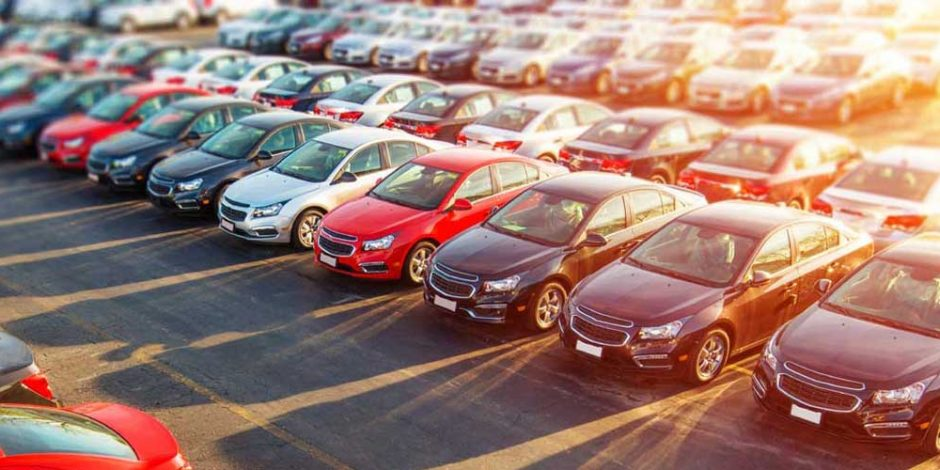

Цель данного ноутбука только парсинг данных с сайта auto.ru 

Чтобы не парсить весь сайт целиком (что будет трудной задачей), необходимо посмотреть на тестовые данные и определить что именно необходимо получить с auto.ru.

<a id='chapters'>План действий:</a>
1. [Загружаем тестовые данные и смотрим их](#p_1)
2. [Получаем список условий для парсинга](#p_2)
3. [Создаем список ссылок на объявления](#p_3)
4. [Парсим данные по списку ссылок](#p_4)
5. [Выводы](#p_5)

Итак, всё есть - приступим.

<p style="color:green">#############################################################################################</p>  

## Импортируем библиотеки

In [18]:
import pandas as pd
import numpy as np
import random
import warnings
warnings.filterwarnings('ignore')

from bs4 import BeautifulSoup
import requests
import re
import time
import json

from datetime import datetime

from tqdm.auto import tqdm, trange

## Собственные функции

In [19]:
# сделаю отдельную функцию задержки
# с рандомным временем задержки в зависимости от номера шага
# (в первый раз забанили на 4943 ссылке)
def time_sleep(step):
    
    # добавлю ещй рандомности к фиксированным перерывам
    a = -0.2
    b = 0.2
    sec_in_min = 60
    
    # сделаем искусственные перерывы в парсинге
    # у нас >37000 карточек обявлений надо спарсить
    if step == 0:
        # если только старт, то нет перерыва
        t = 0
    
    elif step % 10000 == 0:
        # каждые 10000 перерыв будет больше других
        # сделаю перерыв в 10 минут
        t = 10 * sec_in_min + random.uniform(a, b)
    
    elif step % 5000 == 0:
        # каждые 5000 перерыв будет больше других
        # сделаю перерыв в 5 минут
        t = 5 * sec_in_min + random.uniform(a, b)
    
    elif step % 1000 == 0:
        # каждые 1000 перерыв будет больше других
        # сделаю перерыв в 2 минуты
        t = 2 * sec_in_min + random.uniform(a, b)
    
    elif step % 500 == 0:
        # каждые 500 перерыв будет больше других
        # сделаю перерыв в 1 минуту
        t = 1 * sec_in_min + random.uniform(a, b)
   
    elif step % 100 == 0:
        # каждые 100 перерыв будет больше других
        # сделаю перерыв в 1/2 минуты
        t = 0.5 * sec_in_min + random.uniform(a, b) 
    
    else:
        # иначе рандом между двумя числами
        t = random.uniform(0.53, 2.35)
        
    return t

In [39]:
# функция получения данных из объявления
# !Важно. это не последняя версия функции.
#       ввиду того что я наделал ошибок, функцию пришлось корректировать
#       и запускал я её на уже сохраненных файлах

def get_data(soup):
    
    # список для всех данных по объявлению
    all_cars_descriptions = []

    # вытащим ссылку на объявление
    try:
        car_url = soup.find("link", {"rel":"canonical"})['href']
    except:
        car_url = np.NaN

    # получим номер объявления
    try:
        card_id = soup.find('div', class_='CardHead__infoItem CardHead__id').text[2:]
    except:
        card_id = np.NaN   
    
    # получим дату объявления
    try:
        card_data=soup.find('div', class_='CardHead__infoItem CardHead__creationDate').text + " 2021"
        card_data=convert_date(card_data)
    except:
        card_data = np.NaN

    # получим число просмотров объявления
    try:
        views = soup.find('div', class_='CardHead__infoItem CardHead__views').text.replace('\xa0','')
        views = re.findall(r'[0-9]+', str(views))
        card_views_total = views[0]
    except:
        card_views_total = np.NaN
        
    try:
        views = soup.find('div', class_='CardHead__infoItem CardHead__views').text.replace('\xa0','')
        views = re.findall(r'[0-9]+', str(views))
        card_views_today = views[1]
    except:
        card_views_today = np.NaN        
    
    # бренд автомобиля     
    try:    
        brand = soup.find('h1').text.split(' ')[0].upper()
    except:
        brand = np.NaN
  
    # имя модели
    try:
        model_name_full = soup.find('h1').text.split(' ')[1:]
        model_name = model_name_full[0]
    except:
        model_name_full = np.NaN 
        model_name = np.NaN 
    
    # цена автомобиля
    try:
        car_price = soup.find('span', class_='OfferPriceCaption__price').text.replace('\\xa0','').replace('₽','')
    except:
        car_price = np.NaN 
    
    # год выпуска автомобиля
    try:
        production_year = int(soup.find('li', class_='CardInfoRow CardInfoRow_year')\
                              .find_all('span', class_="CardInfoRow__cell")[1].text)
    except:
        production_year = np.NaN
        
    # пробег автомобиля
    try:
        mileage = str(soup.find('li', class_='CardInfoRow CardInfoRow_kmAge')\
                      .find_all('span', class_="CardInfoRow__cell")[1]\
                      .text.replace('\\xa0','')\
                      .replace('км',''))
    except:
        mileage = np.NaN
    
    # тип кузова
    try:
        bodyType = soup.find('li', class_='CardInfoRow CardInfoRow_bodytype')\
                        .find_all('span', class_="CardInfoRow__cell")[1].text
    except:
        bodyType = np.NaN
    
    # цвет автомобиля
    try:
        color = soup.find('li', class_='CardInfoRow CardInfoRow_color')\
                        .find_all('span', class_="CardInfoRow__cell")[1].text
    except:
        color = np.NaN
        
    # двигатель автомобиля
    try:
        eng = soup.find('li', class_='CardInfoRow CardInfoRow_engine')\
                       .find_all('span', class_="CardInfoRow__cell")[1]\
                       .text.replace('\\xa0','').split('/')
        engine_volume = eng[0].strip().replace(' л','')
        engine_power = eng[1].strip().replace('л.с.','')
        engine_type = eng[2].strip().lower()
    except:
        engine_volume = np.NaN
        engine_power = np.NaN
        engine_type = np.NaN
    
    # комплектация автомобиля
    try:
        complectation = soup.find('li', class_='CardInfoRow CardInfoRow_complectationOrEquipmentCount')\
                        .find_all('span', class_="CardInfoRow__cell")[1].text.replace('\xa0',' ')
    except:
        complectation = np.NaN
    
    # транспортный налог
    try:
        tax=soup.find('li', class_='CardInfoRow CardInfoRow_transportTax')\
                        .find_all('span', class_="CardInfoRow__cell")[1].text.replace('\xa0','') 
        transport_tax =  int(re.findall(r'[0-9]+', str(tax))[0])   
    except:
        transport_tax = np.NaN  
        
    # коробка автомобиля
    try:
        transmission = soup.find('li', class_='CardInfoRow CardInfoRow_transmission')\
                        .find_all('span', class_="CardInfoRow__cell")[1].text
    except:
        transmission = np.NaN
        
    # привод автомобиля
    try:
        drive = soup.find('li', class_='CardInfoRow CardInfoRow_drive')\
                        .find_all('span', class_="CardInfoRow__cell")[1].text
    except:
        drive = np.NaN    
    
     # привод автомобиля
    try:
        wheel = soup.find('li', class_='CardInfoRow CardInfoRow_wheel')\
                        .find_all('span', class_="CardInfoRow__cell")[1].text.lower()
    except:
        wheel = np.NaN    
    
     # состояние автомобиля
    try:
        state = soup.find('li', class_='CardInfoRow CardInfoRow_state')\
                        .find_all('span', class_="CardInfoRow__cell")[1].text.lower()
    except:
        state = np.NaN     

    # число владельцев автомобиля
    try:
        owners_count = soup.find('li', class_='CardInfoRow CardInfoRow_ownersCount')\
                        .find_all('span', class_="CardInfoRow__cell")[1].text.lower()
    except:
        owners_count = np.NaN
        
    # ПТС автомобиля
    try:
        pts = soup.find('li', class_='CardInfoRow CardInfoRow_pts')\
                        .find_all('span', class_="CardInfoRow__cell")[1].text.lower()
    except:
        pts = np.NaN
        
    # растаможен автомобиль
    try:
        customs = soup.find('li', class_='CardInfoRow CardInfoRow_customs')\
                        .find_all('span', class_="CardInfoRow__cell")[1].text.lower()
    except:
        customs = np.NaN

    # обмен автомобиля
    try:
        exchange = soup.find('li', class_='CardInfoRow CardInfoRow_exchange')\
                        .find_all('span', class_="CardInfoRow__cell")[1].text.lower()
    except:
        exchange = np.NaN
    
    # 
    try:
        card_city = soup.find('span', class_='MetroListPlace__regionName MetroListPlace_nbsp').text
    except:
        card_city = np.NaN
    
    # выделим время владения автомобилем
    try:
        Владение = soup.find('li', class_="CardInfoRow CardInfoRow_owningTime")\
                        .find_all('span', class_="CardInfoRow__cell")[1].text.lower()
    except:
        Владение = np.NaN
        
    # описание от продавца
    try: 
        description = soup.find('div',class_="CardDescriptionHTML").text
    except:
        description = np.NaN
        
    # ссылка на картинку
    try:
        image = soup.find("link", {"as":"image"})['href']
    except:
        image = np.NaN
    
    # сразу сделаем проверку на призна проданной машины
    try:
        sold_check = soup.find('div', class_ = "CardSold")
        if(sold_check is not None): 
            sold_check = 'Sold'
    except:
        sold_check = np.NaN
   
    
    # покопавшись в ответе на запрос нашел ещё кучку интересного
    # в тэгах script    
    # придется потом много поудалять, тк много дублирующейся информации
    # но это легче чем добавить отсутствующую информацию
    
    scripts_all=[]
    
    for script in soup.find_all("script"):
        
        # комплектация
        if 'complectation":{"id"' in str(script):
            try:
                complectation_dict = re.search(r'complectation":{"id.*?}',str(script))[0][15:]
                if complectation_dict == []:
                    complectation_dict = np.NaN
            except:
                complectation_dict = np.NaN
#         print(complectation_dict)
        
        # оборудование
#         equipment_dict = np.NaN
        if 'equipment":{' in str(script):
            try:
                equipment_dict = re.search(r'equipment":{.*?}',str(script))[0][11:]
            except:
                equipment_dict = np.NaN
  
        # пробег
        if '"mileage":' in str(script):
            try:
                mileage_dict = re.search(r'"mileage":\d*',str(script))[0][10:]
            except:
                if '"mileage":' in str(script):
                    try:
                        mileage_dict = re.search(r'"mileage":\d*',str(script))[0][10:]
                    except:
                        mileage_dict = np.NaN
            
        # информация о модели
        if '"model_info":' in str(script):
            try:
                model_dict = re.search(r'model_info":{.*?}',str(script))[0][12:]
            except:
                model_dict = np.NaN
            
            try:
                model_name_dict=eval(model_dict)['name']
            except:
                model_name_dict = np.NaN            

        # супер-ген
        if 'super_gen":{' in str(script):
            try:
                super_gen_dict = re.search(r'tech_param":{".*?}',str(script))[0][12:]
            except:
                super_gen_dict = np.NaN

        # производитель
        if 'vendor":"' in str(script):
            try:
                vendor_dict = re.search(r'vendor":".*?"',str(script))[0][9:].strip('"')
            except:
                vendor_dict = np.NaN

        # каталог параметров
        if 'catalogParams":{' in str(script):
            try:
                catalogParams_dict = re.search(r'catalogParams":{.*?}',str(script))[0][15:].strip('"')
            except:
                catalogParams_dict = np.NaN

        # информация по машине
        if 'vehicle_info":{' in str(script):
            try:
                vehicle_info_dict = re.search(r'configuration":{.*?}',str(script))[0][15:].strip('"')
            except:
                vehicle_info_dict = np.NaN

        # технические параметры
        if 'tech_param":{' in str(script):
            try:
                tech_param_dict = re.search(r'tech_param":{"id".*?}',str(script))[0][12:].strip('"')
            except:
                tech_param_dict = np.NaN
                

        # engineDisplacement
        if 'engineDisplacement":"' in str(script):
            try:
                engineDisplacement = re.search(r'engineDisplacement":".*?"',str(script))[0][21:].strip('"')
            except:
                engineDisplacement = np.NaN
        else:
            engineDisplacement = np.NaN
        
        
        # enginePower
        if 'enginePower":"' in str(script):
            try:
                enginePower = re.search(r'enginePower":".*?"',str(script))[0][14:].strip('"')
            except:
                enginePower = np.NaN
        else:
            enginePower = np.NaN
                
        # fuelType
        if 'fuelType":"' in str(script):
            try:
                fuelType = re.search(r'fuelType":".*?"',str(script))[0][11:].strip('"')
            except:
                fuelType = np.NaN
        else:
            fuelType = np.NaN
            
        # lk_summary
        if 'lk_summary":"' in str(script):
            try:
                lk_summary = re.search(r'lk_summary":".*?"',str(script))[0][13:].strip(',').replace("\\xa0"," ").partition(',')[0]
            except:
                lk_summary = np.NaN
        else:
            lk_summary = np.NaN
            
        # doors_count
        if 'doors_count":' in str(script):
            try:
                doors_count = re.search(r'doors_count":.*?"',str(script))[0][13:].strip(',"')
            except:
                doors_count = np.NaN
        else:
            doors_count = np.NaN
            
        # offers_dict
        if '"offers":{' in str(script):
            try:
                text=' '.join(re.findall(r'"offers":{([^<>]+)}}', str(script)))

                offers_dict = {}
                for item in text.split(','):#range(len(text.split(','))):
                    key = item.split(':',1)[0]
                    value = item.split(':',1)[1]
                    offers_dict[key] = value
                
                scripts_all.append(str(script))
                
            except:
                offers_dict = np.NaN
        else:
            offers_dict = np.NaN
            
        # справочник прайса
        if 'price_info":{' in str(script):
            try:
                price_info_dict = re.search(r'price_info":{".*?}',str(script))[0][12:]
                if price_info_dict == [] or complectation_dict == '':
                    price_info_dict = np.NaN
            except:
                    price_info_dict = np.NaN
        else:
            engineDisplacement = np.NaN
        
        # справочник изменения цены предложения
        if 'price_history":[' in str(script):
            try:
                price_history_dict = re.search(r'price_history":.*?}',str(script))[0][16:]
                if price_history_dict == [] or complectation_dict == '':
                    price_history_dict = np.NaN
            except:
                    price_history_dict = np.NaN
        else:
            price_history_dict = np.NaN 
        
        # год производства
        if 'productionDate":' in str(script):
            try:
                productionDate = re.search(r'"productionDate":.*?,',str(scr))[0][17:-1]
                if productionDate == [] or productionDate == '':
                    productionDate = np.NaN
            except:
                    productionDate = np.NaN
        else:
            productionDate = np.NaN            
        
        # конфигурация автомобиля
        if 'vehicleConfiguration":' in str(script):
            try:
                vehicleConfiguration = re.search(r'vehicleConfiguration":.*?,',str(scr))[0][23:-2]
                if vehicleConfiguration == [] or vehicleConfiguration == '':
                    vehicleConfiguration = np.NaN
            except:
                    vehicleConfiguration = np.NaN        
        else:
            vehicleConfiguration = np.NaN        
        
    # код валюты объявления
    try:
        priceCurrency = json.loads(price_info_dict)['currency']
    except:
        priceCurrency = np.NaN
    
    # сохраним всё в словарь
    car_description = {'bodyType' : bodyType,
                       'brand' : brand,
                       'car_url' : car_url,
                       'color' : color,
                       'complectation_dict' : complectation_dict,
                       'description' : description,
                       'engineDisplacement' : engineDisplacement,
                       'enginePower' : enginePower,
                       'equipment_dict' : equipment_dict,
                       'fuelType' : fuelType,
                       'image' : image,    
                       'mileage' : mileage,
                       'modelDate' : production_year,    
                       'model_info' : model_dict,
                       'model_name' : model_name_dict,
                       'name' : lk_summary,
                       'numberOfDoors' : doors_count,  
                       'parsing_unixtime': time.mktime(datetime.now().timetuple()), # формат unixtime
                       'priceCurrency' : priceCurrency, 
                       'productionDate' : productionDate,
                       'offers_dict' : offers_dict,
                       'sell_id' : card_id, # переименую,чтобы совпадало с тестовой выборкой
                       'super_gen' : super_gen_dict, # переименую,чтобы совпадало с тестовой выборкой
                       'vehicleConfiguration' : vehicleConfiguration,
                       'vehicleTransmission' : transmission,# переименую,чтобы совпадало с тестовой выборкой                       
                       'vendor' : vendor_dict,# переименую,чтобы совпадало с тестовой выборкой
                       'Владельцы' : owners_count,# переименую,чтобы совпадало с тестовой выборкой
                       'Владение' : Владение,
                       'ПТС' : pts,                       
                       'Привод' : drive,
                       'Руль' : wheel,
                       'Состояние' : state,
                       'Таможня' : customs, 
                       # последним будет признак который нам надо спрогнозировать на тестовой выборке
                       'car_price' : car_price, 

                       # дальше идут дополнительные признаки
                       # добавлю в их наименование первую буку "z_" 
                       # чтобы они всегда отображались в конце алфавитных списков
                       'z_card_data' : card_data,
                       'z_card_views_total' : card_views_total,
                       'z_card_views_today' : card_views_today,
                       'z_model_name_full' : model_name_full,
                       'z_model_name_short' : model_name,

                       'z_engine_volume' : engine_volume,
                       'z_engine_power' : engine_power,
                       'z_engine_type' : engine_type,
                       'z_complectation' : complectation,
                       'z_transport_tax' : transport_tax,
                       'z_card_city' : card_city,
                       'z_mileage_dict' : mileage_dict,
                       'z_catalogParams_dict' : catalogParams_dict,
                       'z_vehicle_info_dict' : vehicle_info_dict,
                       'z_tech_param_dict' : tech_param_dict,
                       'z_sold_check' : sold_check,
                       'z_price_info_dict' : price_info_dict,
                       'z_price_history_dict' : price_history_dict
                      
                      }
    
    for key, value in car_description.items():
        if '\xa0' in str(value):
            car_description[key]=str(value).replace('\xa0','')
    
    return car_description

<p style="color:green">#############################################################################################</p><br>
<font size="5">  
<a id='p_1' style="color:blue">1. Загружаем тестовые данные и смотрим их</a></font> 

[назад к оглавлению](#chapters) | [предыдущая часть](#chapters) | [следующая часть](#p_2)

In [4]:
# читаем исходный файл
test = pd.read_csv('data/test.csv')

In [20]:
test.sample(4).T

,16026,13722,4058,18032
bodyType,седан,хэтчбек 5 дв.,седан,купе-хардтоп
brand,MERCEDES,NISSAN,AUDI,MERCEDES
car_url,https://auto.ru/cars/used/sale/mercedes/s_klas...,https://auto.ru/cars/used/sale/nissan/note/109...,https://auto.ru/cars/used/sale/audi/a4/1101148...,https://auto.ru/cars/used/sale/mercedes/e_klas...
color,чёрный,белый,чёрный,белый
complectation_dict,"{""id"":""21016741"",""name"":""S 560 4MATIC"",""availa...","{""id"":""8505781"",""name"":""Luxury"",""available_opt...",NaN,NaN
description,Внимание! Только для клиентов AVILON Автомобил...,Продаю прекрасный автомобиль. Автомобиль конца...,Переборка двс340000 замена акпп контрактная 35...,Безопасность: 19. Салон: 21. Обзор: 12. Мульти...
engineDisplacement,4.0 LTR,1.6 LTR,2.0 LTR,1.8 LTR
enginePower,469 N12,110 N12,130 N12,184 N12
equipment_dict,"{""cruise-control"":true,""asr"":true,""roller-blin...","{""cruise-control"":true,""asr"":true,""tinted-glas...","{""tinted-glass"":true,""esp"":true,""airbag-driver...","{""asr"":true,""tinted-glass"":true,""roller-blind-..."
fuelType,бензин,бензин,бензин,бензин


In [33]:
# посмотрим на размерность dataset-а
print(f'В тестовых данных {test.shape[0]} записей')
print(f'В тестовых данных {test.shape[1]} признаков')

В тестовых данных 34686 записей
В тестовых данных 32 признаков


Как видно в тестовых данных много признаков (32) и число записей приближается к 35 тысячам.  
Простым просмотром ничего не добиться, посмотрим на число уникальных значений в признаках.

In [26]:
# вначале посмотрим на число уникальных значений в признаках
num_unique = [test[col_name].nunique() for col_name in test.columns]
series_unique = pd.Series(num_unique,index=test.columns)
series_unique

bodyType                   24
brand                      12
car_url                 34686
color                      16
complectation_dict       2364
description             31732
engineDisplacement         55
enginePower               315
equipment_dict          23705
fuelType                    5
image                   34557
mileage                 11268
modelDate                  66
model_info                954
model_name                544
name                     2780
numberOfDoors               5
parsing_unixtime        34686
priceCurrency               1
productionDate             69
sell_id                 34686
super_gen                5890
vehicleConfiguration      634
vehicleTransmission         4
vendor                      2
Владельцы                   3
Владение                  275
ПТС                         2
Привод                      3
Руль                        2
Состояние                   1
Таможня                     1
dtype: int64

In [31]:
# как мне кажется надо посмотреть более детально на следующие признаки
# у остальных либо слишком много, либо слишком мало уникальных значений
looking_columns = ['bodyType','brand','color','fuelType','vehicleTransmission','vendor']
[test[col_name].unique() for col_name in looking_columns]

[array(['лифтбек', 'внедорожник 5 дв.', 'хэтчбек 5 дв.', 'седан',
        'компактвэн', 'универсал 5 дв.', 'пикап одинарная кабина',
        'хэтчбек 3 дв.', 'купе', 'кабриолет', 'минивэн',
        'пикап двойная кабина', 'внедорожник 3 дв.', 'родстер', 'микровэн',
        'седан 2 дв.', 'купе-хардтоп', 'фастбек', 'тарга',
        'внедорожник открытый', 'лимузин', 'пикап полуторная кабина',
        'седан-хардтоп', 'фургон'], dtype=object),
 array(['SKODA', 'AUDI', 'HONDA', 'VOLVO', 'BMW', 'NISSAN', 'INFINITI',
        'MERCEDES', 'TOYOTA', 'LEXUS', 'VOLKSWAGEN', 'MITSUBISHI'],
       dtype=object),
 array(['синий', 'чёрный', 'серый', 'коричневый', 'белый', 'пурпурный',
        'бежевый', 'серебристый', 'красный', 'зелёный', 'жёлтый',
        'голубой', 'оранжевый', 'фиолетовый', 'золотистый', 'розовый'],
       dtype=object),
 array(['бензин', 'дизель', 'гибрид', 'электро', 'газ'], dtype=object),
 array(['роботизированная', 'механическая', 'автоматическая', 'вариатор'],
       dtype=

Получается, что надо сфокусироваться на брендах, парсим все модели по ним. 

<p style="color:green">#############################################################################################</p><br>
<font size="5">  
<a id='p_2' style="color:blue">2. Список условий для парсинга</a></font> 

[назад к оглавлению](#chapters) | [предыдущая часть](#p_1) | [следующая часть](#p_3)

In [5]:
# получим список брендов в тестовой выборке - парсить будем только по этому списку
brands_to_parse = sorted(test.brand.value_counts().index.tolist())

print(f"\nПарсить будем {len(brands_to_parse)} брендов:\n",brands_to_parse)

В тестовых данных 34686 записей

Парсить будем 12 брендов:
 ['AUDI', 'BMW', 'HONDA', 'INFINITI', 'LEXUS', 'MERCEDES', 'MITSUBISHI', 'NISSAN', 'SKODA', 'TOYOTA', 'VOLKSWAGEN', 'VOLVO']





<div class="alert alert-block alert-success">
<b>Важно!</b><br>  
<br>  <font color="black"> 
Также у нас есть ограничение, что auto.ru не выдает более 99 страниц с объявлениями, что в общем то логично - мало кто в состоянии просмотреть все объявление. И обычно при таком количестве страниц пытаются сузить запросы.
Я сделаю тоже самое, создам список по годам для уменьшения страниц выдачи.  

Мудрить не буду - сделаю с начала прошлого века и до следующего года.
</font>
</div>

In [34]:
# сгенерируем список годов для установки фильтра на сайте
list_years=[i for i in range(1900, 2022,1)]
print(list_years)

[1900, 1901, 1902, 1903, 1904, 1905, 1906, 1907, 1908, 1909, 1910, 1911, 1912, 1913, 1914, 1915, 1916, 1917, 1918, 1919, 1920, 1921, 1922, 1923, 1924, 1925, 1926, 1927, 1928, 1929, 1930, 1931, 1932, 1933, 1934, 1935, 1936, 1937, 1938, 1939, 1940, 1941, 1942, 1943, 1944, 1945, 1946, 1947, 1948, 1949, 1950, 1951, 1952, 1953, 1954, 1955, 1956, 1957, 1958, 1959, 1960, 1961, 1962, 1963, 1964, 1965, 1966, 1967, 1968, 1969, 1970, 1971, 1972, 1973, 1974, 1975, 1976, 1977, 1978, 1979, 1980, 1981, 1982, 1983, 1984, 1985, 1986, 1987, 1988, 1989, 1990, 1991, 1992, 1993, 1994, 1995, 1996, 1997, 1998, 1999, 2000, 2001, 2002, 2003, 2004, 2005, 2006, 2007, 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018, 2019, 2020, 2021]


Замечательно, мы готовы парсить)))

<p style="color:green">#############################################################################################</p><br>
<font size="5">  
<a id='p_3' style="color:blue">3. Создаем список ссылок на объявления</a></font> 

[назад к оглавлению](#chapters) | [предыдущая часть](#p_2) | [следующая часть](#p_4)

В этом пункте получаем список ссылок на объявления, по которому уже будем парсить сами объявления.

In [36]:
all_links = [] # список для уникальных ссылок
all_links_as_is = [] # список для всех найденных ссылок
all_number_tickets = 0 # общее число найденных объявлений
link_num = 0 # номер ссылки

<div class="alert alert-block alert-success">
<b>Методика парсинга ссылок на объявления:</b><br>  
<br>  <font color="black"> 
<ol>1. Идем циклом по всем бренда в списке brands_to_parse<br>   
2. Внутри идем циклом по году выпуска автомобиля<br>
3. Получаю ответ от сервера и смотрю сколько объявлений и страниц было найдено по запросу<br>  
4. В зависимости от ответа собираю ссылки на объявления<ul>  
    <li>Объявления не найдены - собственно парсить нечего.</li>  
    <li>Найдена одна страница и сколько-то объявлений - парсим их. </li> 
    <li>Найдено несколько страниц и много объявлений - парсим их.</li> </ul>
</ol>
ПС. Разделение по числу страниц было сделано для отслеживания общего числа полученных ссылок. С первой попытки не получилось сделать простой алгоритм (были какие то потери ссылок). А после такого разделения ошибок не нашел.
</font>
</div>

In [14]:
# пошли циклом по брендам
for brand in brands_to_parse:
    # переведем в нижний регистр, тк на сайте бренды в нижнем регистре
    brand = brand.lower()
    
    # обнуляю список ссылок, тк иначе при сохранении дублировались бренды     
    all_links = []
    
    # создадим статус бар прохода по годам (для удобства контроля)
    pbar_years = tqdm(range(0,len(list_years),2))
    
    # теперь пойдем циклом по годам
    # (тк если брать сразу всё то будет максимальная страница 99, а самих предложений там больше) 
    for year in pbar_years:

        # чтобы не вычислять постоянно года - посчитаем один раз
        try:
            year_start = list_years[year]
            year_finish = list_years[year+1]
        except:
            year_start = list_years[year]
            year_finish = list_years[year]
        
#         это ссылка с фильтром по городу (вначале спарсил Москву)
#         url = f'https://auto.ru/moskva/cars/{brand}/used/?year_from={year_start}&year_to={year_finish}'
        
        # это без ограничения по городу
        url = f'https://auto.ru/cars/{brand}/used/?year_from={year_start}&year_to={year_finish}'
        response = requests.get(url, headers={'User-Agent': 'Mozilla/5.0'})
        response.encoding = 'utf-8'
        soup = BeautifulSoup(response.text, 'html.parser')

        # сделаю обработку ошибок при получении числа страниц
        try:
            pages_number = int(soup.find_all({'a'}, class_='Button Button_color_whiteHoverBlue Button_size_s Button_type_link Button_width_default ListingPagination__page')[-1]\
                     .find_all('span',class_='Button__text')[-1].text)
        except:
            pages_number = 0
        
        # сделаю обработку ошибок при получении числа найденных объявлений 
        try:
            number_tickets = soup.find({'span'}, class_={"ButtonWithLoader__content"}).text
            number_tickets = int(re.findall(r'\d+', number_tickets)[0])
        except:
            try:
                number_tickets = soup.find({'div'}, class_={"ListingCarsFilters__submitButtonEmpty"}).text
                if number_tickets == 'Ничего не найдено':
                    number_tickets = 0
            except:
                number_tickets = 0
                
        # обнуляю список ссылок на странице
        links_as_is = []
        
        # теперь идем по по алгоритму п.4. методики
        # ничего не нашли
        if pages_number == 0 and number_tickets == 0:
            print(f'Объявлений для "{brand}" за период {year_start}-{year_finish} не найдено')

        # нашли только одну страницу с результатами
        elif pages_number == 0 and number_tickets > 0:
            links = []
            
            # соберем все ссылки 
            cars_list = soup.find_all('div', class_='ListingItem__description')

            for item in range(len(cars_list)):
                for link in cars_list[item].find_all('a', class_="Link ListingItemTitle__link", href=True):
                    links_as_is.append(link['href'])
                    # добавим проверку на уже наличие в списке - иначе будут дубли страниц
                    # что приведет к повторному парсингу объявления
                    if link['href'] not in links: 
                        links.append(link['href'])
            
            # добавим собранные ссылки в основной список
            all_links += links
            all_links_as_is += links_as_is
            
            # сохраняю файл с результатами за период
            file = f'all_cities_links_{brand}_{year_start}_{year_finish}.csv'
            pd.DataFrame(links).to_csv(file, header=False, index=False)
            
            # вывожу информационное сообщение
            all_number_tickets += number_tickets
            print(f'"{brand}" за период {year_start}-{year_finish} только одна корневая страница, содержит {number_tickets} объявлений, найдено {len(links_as_is)}, собрано уникальных {len(links)}')
            link_num =+ 1

        # нашли несколько страниц с результатами        
        elif pages_number != 0 and number_tickets > 0:
            
            # обнуляю список ссылок на странице
            links = []

#             url_original = f'https://auto.ru/moskva/cars/{brand}/used/?year_from={year_start}&year_to={year_finish}&page='
            # это без ограничения по городу
            url_original = f'https://auto.ru/cars/{brand}/used/?year_from={year_start}&year_to={year_finish}&page='
            
            number_tickets_found = 0
            
            # идем циклом по страницам
            for page_num in range(1,pages_number+1):
                # добавим задержу между страницами, чтобы не забанили
                time.sleep(time_sleep(link_num))
                
                # составляю ссылку и получаем ответ на запрос
                url = url_original + str(page_num)
                response = requests.get(url, headers={'User-Agent': 'Mozilla/5.0'})
                response.encoding = 'utf-8'
                soup = BeautifulSoup(response.text, 'html.parser')
                
                # находим список ссылок на объявления
                cars_list = soup.find_all('div', class_='ListingItem__thumb')
                
                # считаем число ссылок а списке
                try:
                    number_tickets = soup.find({'span'}, class_={"ButtonWithLoader__content"}).text
                    number_tickets = int(re.findall(r'\d+', number_tickets)[0])
                except:
                    try:
                        number_tickets = soup.find({'div'}, class_={"ListingCarsFilters__submitButtonEmpty"}).text
                        if number_tickets == 'Ничего не найдено':
                            number_tickets = 0
                    except:
                        number_tickets = 0
                
                # собираем ссылки
                for item in range(len(cars_list)):
                    for link in cars_list[item].find_all('a', class_="Link OfferThumb", href=True):
                        link_num =+ 1
                        links_as_is.append(link['href'])
                        
                        # добавим проверку на уже наличие в списке - иначе будут дубли страниц
                        # что приведет к повторному парсингу объявления
                        if link['href'] not in links: 
                            links.append(link['href'])
                            number_tickets_found += 1
                            
                # сохраняю файл с результатами за период   
                file = f'all_cities_links_{brand}_{year_start}_{year_finish}.csv'
                pd.DataFrame(links).to_csv(file, header=False, index=False)
                
            # добавим собранные ссылки в основной список
            all_links += links
            all_links_as_is += links_as_is
            all_number_tickets += number_tickets
            
            # вывожу информационное сообщение
            print(f'"{brand}" за период {year_start}-{year_finish} найдено {pages_number} страниц, содержит {number_tickets} объявлений, найдено {len(links_as_is)}, собрано уникальных {number_tickets_found}')

        else:
            print('Ошибка при нахождении числа страниц и/или числа объявлений')

        # добавим задержу между брендами, чтобы не забанили
        t = random.uniform(0.53, 1.35)
        time.sleep(t)

    # сохраним ссылки в файл для каждого бренда отдельно
    # сохраним полученные ссылки в файл
    file = f'all_cities_links_{brand}.csv'
    pd.DataFrame(all_links).to_csv(file, header=False, index=False)
    
print(f'\nОбщее заявленное число объявлений {all_number_tickets}, собрано уникальных {len(list(set(all_links)))}')

  0%|          | 0/61 [00:00<?, ?it/s]

Объявлений для "audi" за период 1900-1901 не найдено
Объявлений для "audi" за период 1902-1903 не найдено
Объявлений для "audi" за период 1904-1905 не найдено
Объявлений для "audi" за период 1906-1907 не найдено
Объявлений для "audi" за период 1908-1909 не найдено
Объявлений для "audi" за период 1910-1911 не найдено
Объявлений для "audi" за период 1912-1913 не найдено
Объявлений для "audi" за период 1914-1915 не найдено
Объявлений для "audi" за период 1916-1917 не найдено
Объявлений для "audi" за период 1918-1919 не найдено
Объявлений для "audi" за период 1920-1921 не найдено
Объявлений для "audi" за период 1922-1923 не найдено
Объявлений для "audi" за период 1924-1925 не найдено
Объявлений для "audi" за период 1926-1927 не найдено
Объявлений для "audi" за период 1928-1929 не найдено
Объявлений для "audi" за период 1930-1931 не найдено
Объявлений для "audi" за период 1932-1933 не найдено
Объявлений для "audi" за период 1934-1935 не найдено
Объявлений для "audi" за период 1936-1937 не н

  0%|          | 0/61 [00:00<?, ?it/s]

Объявлений для "bmw" за период 1900-1901 не найдено
Объявлений для "bmw" за период 1902-1903 не найдено
Объявлений для "bmw" за период 1904-1905 не найдено
Объявлений для "bmw" за период 1906-1907 не найдено
Объявлений для "bmw" за период 1908-1909 не найдено
Объявлений для "bmw" за период 1910-1911 не найдено
Объявлений для "bmw" за период 1912-1913 не найдено
Объявлений для "bmw" за период 1914-1915 не найдено
Объявлений для "bmw" за период 1916-1917 не найдено
Объявлений для "bmw" за период 1918-1919 не найдено
Объявлений для "bmw" за период 1920-1921 не найдено
Объявлений для "bmw" за период 1922-1923 не найдено
Объявлений для "bmw" за период 1924-1925 не найдено
Объявлений для "bmw" за период 1926-1927 не найдено
Объявлений для "bmw" за период 1928-1929 не найдено
Объявлений для "bmw" за период 1930-1931 не найдено
Объявлений для "bmw" за период 1932-1933 не найдено
Объявлений для "bmw" за период 1934-1935 не найдено
"bmw" за период 1936-1937 только одна корневая страница, содержи

  0%|          | 0/61 [00:00<?, ?it/s]

Объявлений для "honda" за период 1900-1901 не найдено
Объявлений для "honda" за период 1902-1903 не найдено
Объявлений для "honda" за период 1904-1905 не найдено
Объявлений для "honda" за период 1906-1907 не найдено
Объявлений для "honda" за период 1908-1909 не найдено
Объявлений для "honda" за период 1910-1911 не найдено
Объявлений для "honda" за период 1912-1913 не найдено
Объявлений для "honda" за период 1914-1915 не найдено
Объявлений для "honda" за период 1916-1917 не найдено
Объявлений для "honda" за период 1918-1919 не найдено
Объявлений для "honda" за период 1920-1921 не найдено
Объявлений для "honda" за период 1922-1923 не найдено
Объявлений для "honda" за период 1924-1925 не найдено
Объявлений для "honda" за период 1926-1927 не найдено
Объявлений для "honda" за период 1928-1929 не найдено
Объявлений для "honda" за период 1930-1931 не найдено
Объявлений для "honda" за период 1932-1933 не найдено
Объявлений для "honda" за период 1934-1935 не найдено
Объявлений для "honda" за пе

  0%|          | 0/61 [00:00<?, ?it/s]

Объявлений для "infiniti" за период 1900-1901 не найдено
Объявлений для "infiniti" за период 1902-1903 не найдено
Объявлений для "infiniti" за период 1904-1905 не найдено
Объявлений для "infiniti" за период 1906-1907 не найдено
Объявлений для "infiniti" за период 1908-1909 не найдено
Объявлений для "infiniti" за период 1910-1911 не найдено
Объявлений для "infiniti" за период 1912-1913 не найдено
Объявлений для "infiniti" за период 1914-1915 не найдено
Объявлений для "infiniti" за период 1916-1917 не найдено
Объявлений для "infiniti" за период 1918-1919 не найдено
Объявлений для "infiniti" за период 1920-1921 не найдено
Объявлений для "infiniti" за период 1922-1923 не найдено
Объявлений для "infiniti" за период 1924-1925 не найдено
Объявлений для "infiniti" за период 1926-1927 не найдено
Объявлений для "infiniti" за период 1928-1929 не найдено
Объявлений для "infiniti" за период 1930-1931 не найдено
Объявлений для "infiniti" за период 1932-1933 не найдено
Объявлений для "infiniti" за пе

  0%|          | 0/61 [00:00<?, ?it/s]

Объявлений для "lexus" за период 1900-1901 не найдено
Объявлений для "lexus" за период 1902-1903 не найдено
Объявлений для "lexus" за период 1904-1905 не найдено
Объявлений для "lexus" за период 1906-1907 не найдено
Объявлений для "lexus" за период 1908-1909 не найдено
Объявлений для "lexus" за период 1910-1911 не найдено
Объявлений для "lexus" за период 1912-1913 не найдено
Объявлений для "lexus" за период 1914-1915 не найдено
Объявлений для "lexus" за период 1916-1917 не найдено
Объявлений для "lexus" за период 1918-1919 не найдено
Объявлений для "lexus" за период 1920-1921 не найдено
Объявлений для "lexus" за период 1922-1923 не найдено
Объявлений для "lexus" за период 1924-1925 не найдено
Объявлений для "lexus" за период 1926-1927 не найдено
Объявлений для "lexus" за период 1928-1929 не найдено
Объявлений для "lexus" за период 1930-1931 не найдено
Объявлений для "lexus" за период 1932-1933 не найдено
Объявлений для "lexus" за период 1934-1935 не найдено
Объявлений для "lexus" за пе

  0%|          | 0/61 [00:00<?, ?it/s]

Объявлений для "mercedes" за период 1900-1901 не найдено
Объявлений для "mercedes" за период 1902-1903 не найдено
Объявлений для "mercedes" за период 1904-1905 не найдено
Объявлений для "mercedes" за период 1906-1907 не найдено
Объявлений для "mercedes" за период 1908-1909 не найдено
Объявлений для "mercedes" за период 1910-1911 не найдено
Объявлений для "mercedes" за период 1912-1913 не найдено
Объявлений для "mercedes" за период 1914-1915 не найдено
Объявлений для "mercedes" за период 1916-1917 не найдено
Объявлений для "mercedes" за период 1918-1919 не найдено
Объявлений для "mercedes" за период 1920-1921 не найдено
Объявлений для "mercedes" за период 1922-1923 не найдено
Объявлений для "mercedes" за период 1924-1925 не найдено
Объявлений для "mercedes" за период 1926-1927 не найдено
Объявлений для "mercedes" за период 1928-1929 не найдено
Объявлений для "mercedes" за период 1930-1931 не найдено
Объявлений для "mercedes" за период 1932-1933 не найдено
"mercedes" за период 1934-1935 

  0%|          | 0/61 [00:00<?, ?it/s]

Объявлений для "mitsubishi" за период 1900-1901 не найдено
Объявлений для "mitsubishi" за период 1902-1903 не найдено
Объявлений для "mitsubishi" за период 1904-1905 не найдено
Объявлений для "mitsubishi" за период 1906-1907 не найдено
Объявлений для "mitsubishi" за период 1908-1909 не найдено
Объявлений для "mitsubishi" за период 1910-1911 не найдено
Объявлений для "mitsubishi" за период 1912-1913 не найдено
Объявлений для "mitsubishi" за период 1914-1915 не найдено
Объявлений для "mitsubishi" за период 1916-1917 не найдено
Объявлений для "mitsubishi" за период 1918-1919 не найдено
Объявлений для "mitsubishi" за период 1920-1921 не найдено
Объявлений для "mitsubishi" за период 1922-1923 не найдено
Объявлений для "mitsubishi" за период 1924-1925 не найдено
Объявлений для "mitsubishi" за период 1926-1927 не найдено
Объявлений для "mitsubishi" за период 1928-1929 не найдено
Объявлений для "mitsubishi" за период 1930-1931 не найдено
Объявлений для "mitsubishi" за период 1932-1933 не найде

  0%|          | 0/61 [00:00<?, ?it/s]

Объявлений для "nissan" за период 1900-1901 не найдено
Объявлений для "nissan" за период 1902-1903 не найдено
Объявлений для "nissan" за период 1904-1905 не найдено
Объявлений для "nissan" за период 1906-1907 не найдено
Объявлений для "nissan" за период 1908-1909 не найдено
Объявлений для "nissan" за период 1910-1911 не найдено
Объявлений для "nissan" за период 1912-1913 не найдено
Объявлений для "nissan" за период 1914-1915 не найдено
Объявлений для "nissan" за период 1916-1917 не найдено
Объявлений для "nissan" за период 1918-1919 не найдено
Объявлений для "nissan" за период 1920-1921 не найдено
Объявлений для "nissan" за период 1922-1923 не найдено
Объявлений для "nissan" за период 1924-1925 не найдено
Объявлений для "nissan" за период 1926-1927 не найдено
Объявлений для "nissan" за период 1928-1929 не найдено
Объявлений для "nissan" за период 1930-1931 не найдено
Объявлений для "nissan" за период 1932-1933 не найдено
Объявлений для "nissan" за период 1934-1935 не найдено
Объявлений

  0%|          | 0/61 [00:00<?, ?it/s]

Объявлений для "skoda" за период 1900-1901 не найдено
Объявлений для "skoda" за период 1902-1903 не найдено
Объявлений для "skoda" за период 1904-1905 не найдено
Объявлений для "skoda" за период 1906-1907 не найдено
Объявлений для "skoda" за период 1908-1909 не найдено
Объявлений для "skoda" за период 1910-1911 не найдено
Объявлений для "skoda" за период 1912-1913 не найдено
Объявлений для "skoda" за период 1914-1915 не найдено
Объявлений для "skoda" за период 1916-1917 не найдено
Объявлений для "skoda" за период 1918-1919 не найдено
Объявлений для "skoda" за период 1920-1921 не найдено
Объявлений для "skoda" за период 1922-1923 не найдено
Объявлений для "skoda" за период 1924-1925 не найдено
Объявлений для "skoda" за период 1926-1927 не найдено
Объявлений для "skoda" за период 1928-1929 не найдено
Объявлений для "skoda" за период 1930-1931 не найдено
Объявлений для "skoda" за период 1932-1933 не найдено
Объявлений для "skoda" за период 1934-1935 не найдено
Объявлений для "skoda" за пе

  0%|          | 0/61 [00:00<?, ?it/s]

Объявлений для "toyota" за период 1900-1901 не найдено
Объявлений для "toyota" за период 1902-1903 не найдено
Объявлений для "toyota" за период 1904-1905 не найдено
Объявлений для "toyota" за период 1906-1907 не найдено
Объявлений для "toyota" за период 1908-1909 не найдено
Объявлений для "toyota" за период 1910-1911 не найдено
Объявлений для "toyota" за период 1912-1913 не найдено
Объявлений для "toyota" за период 1914-1915 не найдено
Объявлений для "toyota" за период 1916-1917 не найдено
Объявлений для "toyota" за период 1918-1919 не найдено
Объявлений для "toyota" за период 1920-1921 не найдено
Объявлений для "toyota" за период 1922-1923 не найдено
Объявлений для "toyota" за период 1924-1925 не найдено
Объявлений для "toyota" за период 1926-1927 не найдено
Объявлений для "toyota" за период 1928-1929 не найдено
Объявлений для "toyota" за период 1930-1931 не найдено
Объявлений для "toyota" за период 1932-1933 не найдено
Объявлений для "toyota" за период 1934-1935 не найдено
Объявлений

  0%|          | 0/61 [00:00<?, ?it/s]

Объявлений для "volkswagen" за период 1900-1901 не найдено
Объявлений для "volkswagen" за период 1902-1903 не найдено
Объявлений для "volkswagen" за период 1904-1905 не найдено
Объявлений для "volkswagen" за период 1906-1907 не найдено
Объявлений для "volkswagen" за период 1908-1909 не найдено
Объявлений для "volkswagen" за период 1910-1911 не найдено
Объявлений для "volkswagen" за период 1912-1913 не найдено
Объявлений для "volkswagen" за период 1914-1915 не найдено
Объявлений для "volkswagen" за период 1916-1917 не найдено
Объявлений для "volkswagen" за период 1918-1919 не найдено
Объявлений для "volkswagen" за период 1920-1921 не найдено
Объявлений для "volkswagen" за период 1922-1923 не найдено
Объявлений для "volkswagen" за период 1924-1925 не найдено
Объявлений для "volkswagen" за период 1926-1927 не найдено
Объявлений для "volkswagen" за период 1928-1929 не найдено
Объявлений для "volkswagen" за период 1930-1931 не найдено
Объявлений для "volkswagen" за период 1932-1933 не найде

  0%|          | 0/61 [00:00<?, ?it/s]

Объявлений для "volvo" за период 1900-1901 не найдено
Объявлений для "volvo" за период 1902-1903 не найдено
Объявлений для "volvo" за период 1904-1905 не найдено
Объявлений для "volvo" за период 1906-1907 не найдено
Объявлений для "volvo" за период 1908-1909 не найдено
Объявлений для "volvo" за период 1910-1911 не найдено
Объявлений для "volvo" за период 1912-1913 не найдено
Объявлений для "volvo" за период 1914-1915 не найдено
Объявлений для "volvo" за период 1916-1917 не найдено
Объявлений для "volvo" за период 1918-1919 не найдено
Объявлений для "volvo" за период 1920-1921 не найдено
Объявлений для "volvo" за период 1922-1923 не найдено
Объявлений для "volvo" за период 1924-1925 не найдено
Объявлений для "volvo" за период 1926-1927 не найдено
Объявлений для "volvo" за период 1928-1929 не найдено
Объявлений для "volvo" за период 1930-1931 не найдено
Объявлений для "volvo" за период 1932-1933 не найдено
Объявлений для "volvo" за период 1934-1935 не найдено
Объявлений для "volvo" за пе

Ссылки на объявления сохранены по брендам (+ есть промежуточные сохранения по годам, при необходимости можно парсить не всё заново, а с определенного периода - и это очень пригодилось при парсинге).

<p style="color:green">#############################################################################################</p><br>
<font size="5">  
<a id='p_4' style="color:blue">4. Парсим данные по списку ссылок</a></font> 

[назад к оглавлению](#chapters) | [предыдущая часть](#p_3) | [следующая часть](#p_5)

В этом разделе собственно получаем данные из объявлений.  
Вначале посмотрим на количество ссылок для парсинга.

In [37]:
# наш список брендов для парсинга
print(brands_to_parse)

# создам список для числа ссылок
num_links=[]

# пробежимся по файлам и добавим в список число ссылок
for brand in range(0,len(brands_to_parse)):
    brand = brands_to_parse[brand].lower()
    df = pd.read_csv('./data/all_cities_links_'+str(brand)+'.csv',names=['link'])
    num_links.append(len(df))

print('Всего:',sum(num_links),' ссылок')

# Создаем зип-объект из двух списков
zip_of_links = zip(brands_to_parse, num_links)

# Теперь делаем словарь из зип-объекта
dict_of_links = dict(zip_of_links)
display(dict_of_links)

['AUDI', 'BMW', 'HONDA', 'INFINITI', 'LEXUS', 'MERCEDES', 'MITSUBISHI', 'NISSAN', 'SKODA', 'TOYOTA', 'VOLKSWAGEN', 'VOLVO']
Всего: 98190  ссылок


{'AUDI': 6910,
 'BMW': 10946,
 'HONDA': 4374,
 'INFINITI': 1421,
 'LEXUS': 2861,
 'MERCEDES': 12265,
 'MITSUBISHI': 7067,
 'NISSAN': 12699,
 'SKODA': 6363,
 'TOYOTA': 17549,
 'VOLKSWAGEN': 13424,
 'VOLVO': 2311}

## Запускаем сам парсинг

<div class="alert alert-block alert-success">
<b>Методика парсинга объявлений:</b><br>  
<br>  <font color="black"> 
<ol>1. Идем циклом по всем брендам в списке brands_to_parse. Считываем собранные ссылки из сохраненного файла;<br>   
2. Делаем запрос и получаем ответ от сервера, после создаем обект soup;<br>
3. Делаю проверку на признак продажи автомобиля (не продана она ли уже);<br>
4. Парсю ответ сервера функцией "get_data";<br>  
5. В зависимости от ответа проверки добавляю суффикс к имени файла:<ul>  
    <li>Признак продажи не найден - "_ok";</li>  
    <li>Признак продажи найден - "_sold";</li> 
    <li>Страница не найдена - "_error".</li></ul><br>
6. Сохраняю объект soup в отдельный файл;<br>
7. По окончании ссылок бренда - сохраняю итоговый dataset бренда в csv файл.
</ol>
ПС. Мысль про сохранение результатов запросов в файл пришла сразу же, так как парсить надо много и это процесс небыстрый. А поскольку велика ошибка при получении данных из ответа сервера (те я некорректно получил например год выпуска автомобиля), то получилось бы, что надо переобращаться к серверу после исправления ошибки. А при наличии файлов это исправить относительно легко и относительно быстро (здесь не нужны временные задержки между файлами и производительность ограничена только мощностью используемого ПК) - пробегаем исправленной функцией по сохраненным файлам.
</font>
</div>

In [10]:
cars_error_of_parsing = [] # список для ссылок с ошибкой при парсинге
cars_sold = [] # список для ссылок уже проданных машин
cars_deleted = [] # список для ссылок уже удаленных машин
count = 0 # счетчик для промежуточного сохранения файла бренда
list_encoding = ['cp1251','utf-8']

# пошли циклом по брендам
for brand in range(0,len(brands_to_parse)):
    # получим имя бренда и дальше будем оперировать с ним
    brand = brands_to_parse[brand].lower()
   
    # получим ссылки из файла
    all_links = pd.read_csv('./data/all_cities_links_'+str(brand)+'.csv',names=['link'])
    
    # обнулим список с данными парсинга    
    cars_data = [] 
    
    # блок ниже для перезапуска парсинга с нужной ссылки
    if brand == 'audi':
        pbar_links = tqdm(range(0,len(all_links)))
#         pbar_links = tqdm(range(0,35))
    else:
        pbar_links = tqdm(range(0,len(all_links)))

    # для каждой ссылки загрузим страницу, 
    # проверим не продана ли машина и 
    # соберем данные объявления функцией get_data
    for item in pbar_links:
        count += 1
        pbar_links.set_description(str(brand) + " парсим ссылку " + str(item+1))

        # берем ссылку    
        url = all_links.link.iloc[item]

        # поставлю случайную задержку перед каждым запросом
        time.sleep(time_sleep(item))

        # парсим через обработчик ошибок
        try:
            response = requests.get(url)
            response.encoding = 'utf-8'
            soup = BeautifulSoup(response.text, 'html.parser')

            # сделаю проверку на статус машины, если продана - то нам объявление уже не нужно (цены там уже нет)
            # но файл мы всё равно сохраним с префиксом "sold"
            sold_check = soup.find('div', class_ = "CardSold")
            if (sold_check is None):
                cars_data.append(get_data(soup))
                after_fix = '_ok'
            else:
                cars_sold.append(url)
                print(url, "Продано - url добавлен в список 'cars_sold'")
                after_fix = '_sold'
            
        except:
            print(url, 'ОШИБКА - url добавлен в список "cars_error_of_parsing"')
            cars_error_of_parsing.append(url)
            after_fix = '_error'
        
        # папка ждля сохранения файлов объявлений
        save_path = './data/parsing_all/'
        
        # найдем номер объявления через обработчик ошибок
        try:
            card_id = str(soup.find('div', class_='CardHead__infoItem CardHead__id').text[2:])
        except:
            card_id = 0
        
        # если номер нашли - сохраняем объект soup.
        if card_id == 0:
            print(url, '- card was deleted')
            cars_deleted.append(url)
            pass
        else:
            file_name = str(save_path) + 'all_train_' + str(card_id) + str(after_fix) + '.txt'
            with open(file_name, mode='w', encoding='utf-8') as file:
                file.write(str(soup))
        
        # сохраним промежуточные результаты парсинга в файле
        if count % 25 == 0:
            pd.DataFrame(cars_data).to_csv('all_auto_ru_data_'+ str(brand) + '_30_11.csv', index = False, encoding=list_encoding[1])

    # создадим итоговый датафрейм и сохраним его в файле
    pd.DataFrame(cars_data).to_csv('all_auto_ru_data_'+ str(brand) + '_30_11.csv', index = False, encoding=list_encoding[1])

    # сохранем все остальные списки
    pd.DataFrame(cars_sold).to_csv('all_auto_ru_sold_'+ str(brand) + '_30_11.csv', index = False, encoding=list_encoding[1])
    pd.DataFrame(cars_deleted).to_csv('all_auto_ru_deleted_'+ str(brand) + '_30_11.csv', index = False, encoding=list_encoding[1])
    pd.DataFrame(cars_error_of_parsing).to_csv('all_auto_ru_error_'+ str(brand) + '_30_11.csv', index = False, encoding=list_encoding[1])

    
print("Собрали датасет для обучения")

  0%|          | 0/6910 [00:00<?, ?it/s]

https://auto.ru/cars/used/sale/audi/100/1106094998-45078ab3/ Sold - url added to list 'cars_sold'
https://auto.ru/cars/used/sale/audi/80/1105779540-0e2c8306/ Sold - url added to list 'cars_sold'
https://auto.ru/cars/used/sale/audi/100/1106083893-bae4ad68/ Sold - url added to list 'cars_sold'
https://auto.ru/cars/used/sale/audi/80/1106020207-256d34cc/ Sold - url added to list 'cars_sold'
https://auto.ru/cars/used/sale/audi/80/1105059013-960433d8/ Sold - url added to list 'cars_sold'
https://auto.ru/cars/used/sale/audi/80/1106052533-a4e139b2/ Sold - url added to list 'cars_sold'
https://auto.ru/cars/used/sale/audi/100/1106058108-9164ec42/ Sold - url added to list 'cars_sold'
https://auto.ru/cars/used/sale/audi/80/1106124196-3d28809f/ Sold - url added to list 'cars_sold'
https://auto.ru/cars/used/sale/audi/80/1106069443-87280c6b/ Sold - url added to list 'cars_sold'
https://auto.ru/cars/used/sale/audi/100/1105997284-e0045e1e/ Sold - url added to list 'cars_sold'
https://auto.ru/cars/used/

https://auto.ru/cars/used/sale/audi/a5/1105968706-296d8a44/ Sold - url added to list 'cars_sold'
https://auto.ru/cars/used/sale/audi/q5/1106134344-920e90e9/ Sold - url added to list 'cars_sold'
https://auto.ru/cars/used/sale/audi/a5/1105637268-fc7b7a66/ Sold - url added to list 'cars_sold'
https://auto.ru/cars/used/sale/audi/a5/1106005645-98a46f48/ Sold - url added to list 'cars_sold'
https://auto.ru/cars/used/sale/audi/q5/1106103302-9249319e/ Sold - url added to list 'cars_sold'
https://auto.ru/cars/used/sale/audi/q5/1106056513-e5f6b7c5/ Sold - url added to list 'cars_sold'
https://auto.ru/cars/used/sale/audi/a3/1106005676-d4924419/ Sold - url added to list 'cars_sold'
https://auto.ru/cars/used/sale/audi/a8/1106007025-1516f1a4/ Sold - url added to list 'cars_sold'
https://auto.ru/cars/used/sale/audi/a6/1106005685-7947cde8/ Sold - url added to list 'cars_sold'
https://auto.ru/cars/used/sale/audi/a6/1106007097-d83ced5f/ Sold - url added to list 'cars_sold'
https://auto.ru/cars/used/sale

https://auto.ru/cars/used/sale/audi/a6/1105340270-b237166e/ Sold - url added to list 'cars_sold'
https://auto.ru/cars/used/sale/audi/a4/1106013906-be6a65aa/ Sold - url added to list 'cars_sold'
https://auto.ru/cars/used/sale/audi/q3/1106005768-9bc7d856/ Sold - url added to list 'cars_sold'
https://auto.ru/cars/used/sale/audi/a1/1106007120-006adfe3/ Sold - url added to list 'cars_sold'
https://auto.ru/cars/used/sale/audi/q7/1106006216-4fe4296d/ Sold - url added to list 'cars_sold'
https://auto.ru/cars/used/sale/audi/a5/1106006267-a5fd1cab/ Sold - url added to list 'cars_sold'
https://auto.ru/cars/used/sale/audi/q7/1106007072-6115e9cb/ Sold - url added to list 'cars_sold'
https://auto.ru/cars/used/sale/audi/a6/1105987348-ef7fec0c/ Sold - url added to list 'cars_sold'
https://auto.ru/cars/used/sale/audi/a4/1105967137-7190f5bc/ Sold - url added to list 'cars_sold'
https://auto.ru/cars/used/sale/audi/rs7/1105961506-6365d8b5/ Sold - url added to list 'cars_sold'
https://auto.ru/cars/used/sal

https://auto.ru/cars/used/sale/audi/a6/1105765721-05de7aec/ Sold - url added to list 'cars_sold'
https://auto.ru/cars/used/sale/audi/q8/1106134271-85023d8d/ Sold - url added to list 'cars_sold'
https://auto.ru/cars/used/sale/audi/a6/1105044410-4ec235e7/ Sold - url added to list 'cars_sold'
https://auto.ru/cars/used/sale/audi/allroad/1105936060-73a6911e/ Sold - url added to list 'cars_sold'
https://auto.ru/cars/used/sale/audi/a4/1105033180-6c895e92/ Sold - url added to list 'cars_sold'
https://auto.ru/cars/used/sale/audi/q3/1106113081-bd0b1dc0/ Sold - url added to list 'cars_sold'
https://auto.ru/cars/used/sale/audi/q7/1105999344-5894f057/ Sold - url added to list 'cars_sold'
https://auto.ru/cars/used/sale/audi/a5/1106101480-f19bf744/ Sold - url added to list 'cars_sold'
https://auto.ru/cars/used/sale/audi/a4/1106093907-838cac41/ Sold - url added to list 'cars_sold'
https://auto.ru/cars/used/sale/audi/q5/1105743913-feb38885/ Sold - url added to list 'cars_sold'
https://auto.ru/cars/used

  0%|          | 0/10946 [00:00<?, ?it/s]

https://auto.ru/cars/used/sale/bmw/5er/1103177231-69c95f77/ Something was going wrong - url added to list "cars_error_of_parsing"
https://auto.ru/cars/used/sale/bmw/5er/1103177231-69c95f77/ - card was deleted
https://auto.ru/cars/used/sale/bmw/3er/1105767669-6a2ce283/ Sold - url added to list 'cars_sold'
https://auto.ru/cars/used/sale/bmw/7er/1105658805-f6b7c515/ Sold - url added to list 'cars_sold'
https://auto.ru/cars/used/sale/bmw/7er/1106112276-64037780/ Sold - url added to list 'cars_sold'
https://auto.ru/cars/used/sale/bmw/7er/1104976153-e47ce05a/ Sold - url added to list 'cars_sold'
https://auto.ru/cars/used/sale/bmw/5er/1106099605-92e9871a/ Sold - url added to list 'cars_sold'
https://auto.ru/cars/used/sale/bmw/3er/1105909462-268d8875/ Sold - url added to list 'cars_sold'
https://auto.ru/cars/used/sale/bmw/5er/1105368245-b3d69d07/ Sold - url added to list 'cars_sold'
https://auto.ru/cars/used/sale/bmw/7er/1105491751-af0fdd9b/ Sold - url added to list 'cars_sold'
https://auto.ru

https://auto.ru/cars/used/sale/bmw/5er/1102499916-3690be27/ Sold - url added to list 'cars_sold'
https://auto.ru/cars/used/sale/bmw/3er/1103939264-ce3ea92e/ Sold - url added to list 'cars_sold'
https://auto.ru/cars/used/sale/bmw/x5/1104908135-95f85d25/ Sold - url added to list 'cars_sold'
https://auto.ru/cars/used/sale/bmw/7er/1105418339-751b7a93/ Sold - url added to list 'cars_sold'
https://auto.ru/cars/used/sale/bmw/6er/1102695305-ff7ce3ac/ Sold - url added to list 'cars_sold'
https://auto.ru/cars/used/sale/bmw/3er/1105279537-d0b7a8bc/ Sold - url added to list 'cars_sold'
https://auto.ru/cars/used/sale/bmw/3er/1105469451-984a33d6/ Sold - url added to list 'cars_sold'
https://auto.ru/cars/used/sale/bmw/5er/1106009921-2e70ab8e/ Sold - url added to list 'cars_sold'
https://auto.ru/cars/used/sale/bmw/x5/1105650041-ca4cea63/ - card was deleted
https://auto.ru/cars/used/sale/bmw/x3/1105503298-d552d70c/ Sold - url added to list 'cars_sold'
https://auto.ru/cars/used/sale/bmw/x5/1105953860-48

https://auto.ru/cars/used/sale/bmw/1er/1105396737-28d94924/ Sold - url added to list 'cars_sold'
https://auto.ru/cars/used/sale/bmw/5er/1104235794-82083c1e/ Sold - url added to list 'cars_sold'
https://auto.ru/cars/used/sale/bmw/x5/1106077259-ee5d5ead/ Sold - url added to list 'cars_sold'
https://auto.ru/cars/used/sale/bmw/5er/1106092577-37933bce/ Sold - url added to list 'cars_sold'
https://auto.ru/cars/used/sale/bmw/5er/1105431388-38d127f1/ Sold - url added to list 'cars_sold'
https://auto.ru/cars/used/sale/bmw/1er/1106101899-636c5ce4/ Sold - url added to list 'cars_sold'
https://auto.ru/cars/used/sale/bmw/5er/1106057488-04377200/ Sold - url added to list 'cars_sold'
https://auto.ru/cars/used/sale/bmw/5er/1106054218-e8c4a634/ Sold - url added to list 'cars_sold'
https://auto.ru/cars/used/sale/bmw/x1/1106127679-d60caad5/ Sold - url added to list 'cars_sold'
https://auto.ru/cars/used/sale/bmw/5er/1106124490-286961fa/ Sold - url added to list 'cars_sold'
https://auto.ru/cars/used/sale/b

https://auto.ru/cars/used/sale/bmw/3er/1105772593-2fd5c3b2/ Sold - url added to list 'cars_sold'
https://auto.ru/cars/used/sale/bmw/x6/1105518178-4a9e4b32/ Sold - url added to list 'cars_sold'
https://auto.ru/cars/used/sale/bmw/7er/1105624698-c24a4fdc/ Sold - url added to list 'cars_sold'
https://auto.ru/cars/used/sale/bmw/x1/1105746873-0f2b1538/ Sold - url added to list 'cars_sold'
https://auto.ru/cars/used/sale/bmw/x5/1105393750-295edf5a/ Sold - url added to list 'cars_sold'
https://auto.ru/cars/used/sale/bmw/5er/1105454784-b39d75bc/ Sold - url added to list 'cars_sold'
https://auto.ru/cars/used/sale/bmw/x5/1105797113-e640217f/ Sold - url added to list 'cars_sold'
https://auto.ru/cars/used/sale/bmw/x5/1106087999-4a3a8890/ Sold - url added to list 'cars_sold'
https://auto.ru/cars/used/sale/bmw/3er/1105542034-193c0abc/ Sold - url added to list 'cars_sold'
https://auto.ru/cars/used/sale/bmw/4/1104962553-96996473/ Sold - url added to list 'cars_sold'
https://auto.ru/cars/used/sale/bmw/5e

https://auto.ru/cars/used/sale/bmw/1er/1106006710-a45ce7fb/ Sold - url added to list 'cars_sold'
https://auto.ru/cars/used/sale/bmw/x3/1106005956-2b6c005c/ Sold - url added to list 'cars_sold'
https://auto.ru/cars/used/sale/bmw/3er/1106049972-b9947029/ Sold - url added to list 'cars_sold'
https://auto.ru/cars/used/sale/bmw/x4/1106035645-b4602996/ Sold - url added to list 'cars_sold'
https://auto.ru/cars/used/sale/bmw/x6/1106035627-cb38841c/ Sold - url added to list 'cars_sold'
https://auto.ru/cars/used/sale/bmw/7er/1106032667-dc41b176/ Sold - url added to list 'cars_sold'
https://auto.ru/cars/used/sale/bmw/x1/1106029908-31e4c392/ Sold - url added to list 'cars_sold'
https://auto.ru/cars/used/sale/bmw/x4/1105973121-e6cdcd4e/ Sold - url added to list 'cars_sold'
https://auto.ru/cars/used/sale/bmw/x3/1105944457-0e64d4ce/ Sold - url added to list 'cars_sold'
https://auto.ru/cars/used/sale/bmw/x6/1105824156-077c3e71/ Sold - url added to list 'cars_sold'
https://auto.ru/cars/used/sale/bmw/3e

https://auto.ru/cars/used/sale/bmw/i3/1105702237-e66732a0/ Sold - url added to list 'cars_sold'
https://auto.ru/cars/used/sale/bmw/6er/1106001782-eec3c014/ Sold - url added to list 'cars_sold'
https://auto.ru/cars/used/sale/bmw/x7/1106018813-4768cc66/ - card was deleted
https://auto.ru/cars/used/sale/bmw/x4/1101168370-4f44f918/ Sold - url added to list 'cars_sold'
https://auto.ru/cars/used/sale/bmw/3er/1105254663-f5d302b4/ Sold - url added to list 'cars_sold'
https://auto.ru/cars/used/sale/bmw/x2/1105954439-ae897811/ Sold - url added to list 'cars_sold'
https://auto.ru/cars/used/sale/bmw/x3/1106004826-a34a1736/ Sold - url added to list 'cars_sold'
https://auto.ru/cars/used/sale/bmw/5er/1103991319-21d658a6/ Sold - url added to list 'cars_sold'
https://auto.ru/cars/used/sale/bmw/x1/1105131905-59a81195/ Sold - url added to list 'cars_sold'
https://auto.ru/cars/used/sale/bmw/x3/1105121284-8b25f83b/ Sold - url added to list 'cars_sold'
https://auto.ru/cars/used/sale/bmw/x5/1104658611-01c090

  0%|          | 0/4374 [00:00<?, ?it/s]

https://auto.ru/cars/used/sale/honda/civic/1096777604-155335d2/ Something was going wrong - url added to list "cars_error_of_parsing"
https://auto.ru/cars/used/sale/honda/civic/1106108539-8a666476/ Sold - url added to list 'cars_sold'
https://auto.ru/cars/used/sale/honda/civic/1103553537-21036c3f/ Sold - url added to list 'cars_sold'
https://auto.ru/cars/used/sale/honda/accord/1104785334-37bda411/ Sold - url added to list 'cars_sold'
https://auto.ru/cars/used/sale/honda/civic/1105425156-59bf1bc6/ Sold - url added to list 'cars_sold'
https://auto.ru/cars/used/sale/honda/civic/1106132498-1a00a5c7/ Sold - url added to list 'cars_sold'
https://auto.ru/cars/used/sale/honda/inspire/1105951062-174bb227/ Sold - url added to list 'cars_sold'
https://auto.ru/cars/used/sale/honda/accord/1105460653-878a0121/ Sold - url added to list 'cars_sold'
https://auto.ru/cars/used/sale/honda/ascot_innova/1106073203-6114d57e/ Sold - url added to list 'cars_sold'
https://auto.ru/cars/used/sale/honda/civic/1105

https://auto.ru/cars/used/sale/honda/cr_v/1105953742-d6b784ad/ Sold - url added to list 'cars_sold'
https://auto.ru/cars/used/sale/honda/civic/1104819687-a357299e/ Sold - url added to list 'cars_sold'
https://auto.ru/cars/used/sale/honda/civic_type_r/1106104423-d1cc2c19/ Sold - url added to list 'cars_sold'
https://auto.ru/cars/used/sale/honda/accord/1105968747-da9b2fe1/ Sold - url added to list 'cars_sold'
https://auto.ru/cars/used/sale/honda/civic/1105288455-a7c4e7d9/ Sold - url added to list 'cars_sold'
https://auto.ru/cars/used/sale/honda/accord/1105985105-a32e03bb/ Sold - url added to list 'cars_sold'
https://auto.ru/cars/used/sale/honda/civic/1105921015-f4458145/ Sold - url added to list 'cars_sold'
https://auto.ru/cars/used/sale/honda/cr_v/1106104108-c2f56e50/ Sold - url added to list 'cars_sold'
https://auto.ru/cars/used/sale/honda/civic_type_r/1105061813-faaa4f4c/ Sold - url added to list 'cars_sold'
https://auto.ru/cars/used/sale/honda/fit/1106037197-9e33b1d2/ Sold - url adde

https://auto.ru/cars/used/sale/honda/cr_v/1105374861-e30c0d4b/ Sold - url added to list 'cars_sold'
https://auto.ru/cars/used/sale/honda/cr_v/1106125648-2439a82b/ Sold - url added to list 'cars_sold'
https://auto.ru/cars/used/sale/honda/fit_shuttle/1105529992-776be723/ Sold - url added to list 'cars_sold'
https://auto.ru/cars/used/sale/honda/freed/1106028250-b559515e/ Sold - url added to list 'cars_sold'
https://auto.ru/cars/used/sale/honda/cr_v/1105867921-851a843f/ Sold - url added to list 'cars_sold'
https://auto.ru/cars/used/sale/honda/civic/1105547089-3bf434e0/ Sold - url added to list 'cars_sold'
https://auto.ru/cars/used/sale/honda/cr_v/1105727625-9605839d/ Sold - url added to list 'cars_sold'
https://auto.ru/cars/used/sale/honda/civic/1106063447-01178f40/ Sold - url added to list 'cars_sold'
https://auto.ru/cars/used/sale/honda/freed/1105891580-e8e949ab/ Sold - url added to list 'cars_sold'
https://auto.ru/cars/used/sale/honda/stepwagon/1105811050-8b15d6ab/ Sold - url added to l

  0%|          | 0/1421 [00:00<?, ?it/s]

https://auto.ru/cars/used/sale/infiniti/q/1106091491-eec7f50a/ Sold - url added to list 'cars_sold'
https://auto.ru/cars/used/sale/infiniti/qx4/1103051110-391e034a/ Sold - url added to list 'cars_sold'
https://auto.ru/cars/used/sale/infiniti/fx/1105733780-cec7e5f5/ Sold - url added to list 'cars_sold'
https://auto.ru/cars/used/sale/infiniti/fx/1106093946-454db0d8/ Sold - url added to list 'cars_sold'
https://auto.ru/cars/used/sale/infiniti/fx/1106004393-46ce753d/ Sold - url added to list 'cars_sold'
https://auto.ru/cars/used/sale/infiniti/g35/1106108550-3f7c6621/ Sold - url added to list 'cars_sold'
https://auto.ru/cars/used/sale/infiniti/fx/1103452445-7fe8cebf/ Sold - url added to list 'cars_sold'
https://auto.ru/cars/used/sale/infiniti/fx/1094011188-c481323d/ Sold - url added to list 'cars_sold'
https://auto.ru/cars/used/sale/infiniti/fx/1106130657-1b2616b5/ Sold - url added to list 'cars_sold'
https://auto.ru/cars/used/sale/infiniti/g35/1106055953-f9ad9545/ Sold - url added to list 

  0%|          | 0/2861 [00:00<?, ?it/s]

https://auto.ru/cars/used/sale/lexus/gs/1105785700-88ad81a1/ Sold - url added to list 'cars_sold'
https://auto.ru/cars/used/sale/lexus/rx/1105950406-101ee977/ Sold - url added to list 'cars_sold'
https://auto.ru/cars/used/sale/lexus/is/1106101897-22708b8b/ Sold - url added to list 'cars_sold'
https://auto.ru/cars/used/sale/lexus/gx/1106066859-e436431a/ Sold - url added to list 'cars_sold'
https://auto.ru/cars/used/sale/lexus/gx/1105846536-b31e5ef2/ Sold - url added to list 'cars_sold'
https://auto.ru/cars/used/sale/lexus/rx/1105877972-5c93cb4a/ Sold - url added to list 'cars_sold'
https://auto.ru/cars/used/sale/lexus/rx/1105638265-056fac28/ Sold - url added to list 'cars_sold'
https://auto.ru/cars/used/sale/lexus/rx/1106117158-f841728b/ Sold - url added to list 'cars_sold'
https://auto.ru/cars/used/sale/lexus/ls/1106065990-f2724242/ Sold - url added to list 'cars_sold'
https://auto.ru/cars/used/sale/lexus/gx/1105057142-c013f9c9/ Sold - url added to list 'cars_sold'
https://auto.ru/cars

https://auto.ru/cars/used/sale/lexus/lx/1106072282-9ab694ab/ Sold - url added to list 'cars_sold'
https://auto.ru/cars/used/sale/lexus/rx/1106070345-95d8a8ec/ Sold - url added to list 'cars_sold'
https://auto.ru/cars/used/sale/lexus/rx/1106066892-8169d36d/ Sold - url added to list 'cars_sold'
https://auto.ru/cars/used/sale/lexus/rx/1106047533-de1b8b74/ Sold - url added to list 'cars_sold'
https://auto.ru/cars/used/sale/lexus/nx/1105016377-32f751d9/ Sold - url added to list 'cars_sold'
https://auto.ru/cars/used/sale/lexus/rx/1106039355-d73c9398/ Sold - url added to list 'cars_sold'
https://auto.ru/cars/used/sale/lexus/rx/1106012783-fefe83a6/ Sold - url added to list 'cars_sold'
https://auto.ru/cars/used/sale/lexus/ls/1106025907-ee47074e/ Sold - url added to list 'cars_sold'
https://auto.ru/cars/used/sale/lexus/gx/1106014193-8c3fd147/ Sold - url added to list 'cars_sold'
https://auto.ru/cars/used/sale/lexus/rx/1106007019-94d4a2b4/ Sold - url added to list 'cars_sold'
https://auto.ru/cars

https://auto.ru/cars/used/sale/lexus/gx/1106007897-75a67cbc/ Sold - url added to list 'cars_sold'
https://auto.ru/cars/used/sale/lexus/gx/1106005786-eb7d93d7/ Sold - url added to list 'cars_sold'
https://auto.ru/cars/used/sale/lexus/nx/1106043350-ef4e8d60/ Sold - url added to list 'cars_sold'
https://auto.ru/cars/used/sale/lexus/lx/1106007159-5f0c2326/ Sold - url added to list 'cars_sold'
https://auto.ru/cars/used/sale/lexus/rx/1106035211-3e1e955a/ Sold - url added to list 'cars_sold'
https://auto.ru/cars/used/sale/lexus/lx/1105979048-9c29da2f/ Sold - url added to list 'cars_sold'
https://auto.ru/cars/used/sale/lexus/lx/1105954469-e48a30bb/ Sold - url added to list 'cars_sold'
https://auto.ru/cars/used/sale/lexus/es/1105907701-a0f078e9/ Sold - url added to list 'cars_sold'
https://auto.ru/cars/used/sale/lexus/gx/1105907700-6b798655/ Sold - url added to list 'cars_sold'
https://auto.ru/cars/used/sale/lexus/rx/1105298398-39aa94d6/ Sold - url added to list 'cars_sold'
https://auto.ru/cars

  0%|          | 0/12265 [00:00<?, ?it/s]

https://auto.ru/cars/used/sale/mercedes/sl_klasse/1104143138-699532f7/ Sold - url added to list 'cars_sold'
https://auto.ru/cars/used/sale/mercedes/w115/1105643664-64b1cd75/ Sold - url added to list 'cars_sold'
https://auto.ru/cars/used/sale/mercedes/w201/1106122123-de6c0a69/ Sold - url added to list 'cars_sold'
https://auto.ru/cars/used/sale/mercedes/g_klasse/1103150851-690057fb/ Sold - url added to list 'cars_sold'
https://auto.ru/cars/used/sale/mercedes/g_klasse/1105656581-5e8838d0/ Sold - url added to list 'cars_sold'
https://auto.ru/cars/used/sale/mercedes/w201/1105877278-67e8b426/ Sold - url added to list 'cars_sold'
https://auto.ru/cars/used/sale/mercedes/w123/1103418986-9def832e/ Sold - url added to list 'cars_sold'
https://auto.ru/cars/used/sale/mercedes/w124/1106087213-dc6c3bff/ Sold - url added to list 'cars_sold'
https://auto.ru/cars/used/sale/mercedes/w201/1104945960-e9356552/ Sold - url added to list 'cars_sold'
https://auto.ru/cars/used/sale/mercedes/w124/1104675093-bd9f

https://auto.ru/cars/used/sale/mercedes/s_klasse/1100296144-b9918f50/ Sold - url added to list 'cars_sold'
https://auto.ru/cars/used/sale/mercedes/m_klasse/1094376942-e81996fd/ Sold - url added to list 'cars_sold'
https://auto.ru/cars/used/sale/mercedes/c_klasse/1104142179-d706fc9f/ Sold - url added to list 'cars_sold'
https://auto.ru/cars/used/sale/mercedes/c_klasse/1103783783-8b476089/ Sold - url added to list 'cars_sold'
https://auto.ru/cars/used/sale/mercedes/c_klasse/1105609890-5406fa26/ Sold - url added to list 'cars_sold'
https://auto.ru/cars/used/sale/mercedes/cls_klasse/1105505280-d50cae36/ Sold - url added to list 'cars_sold'
https://auto.ru/cars/used/sale/mercedes/s_klasse/1106116029-c629ea6a/ Sold - url added to list 'cars_sold'
https://auto.ru/cars/used/sale/mercedes/m_klasse/1104739786-b935fe27/ - card was deleted
https://auto.ru/cars/used/sale/mercedes/cls_klasse/1106022092-3925e5d4/ Sold - url added to list 'cars_sold'
https://auto.ru/cars/used/sale/mercedes/cl_klasse/1

https://auto.ru/cars/used/sale/mercedes/cl_klasse/1106071092-cdb4475d/ Sold - url added to list 'cars_sold'
https://auto.ru/cars/used/sale/mercedes/e_klasse/1105886421-cc5e1dc3/ Sold - url added to list 'cars_sold'
https://auto.ru/cars/used/sale/mercedes/clc_klasse/1106048543-8911b5b4/ Sold - url added to list 'cars_sold'
https://auto.ru/cars/used/sale/mercedes/gl_klasse/1106049445-f54035b9/ Sold - url added to list 'cars_sold'
https://auto.ru/cars/used/sale/mercedes/c_klasse/1106000312-0cd55b74/ Sold - url added to list 'cars_sold'
https://auto.ru/cars/used/sale/mercedes/glk_klasse/1104956089-91aadc63/ Sold - url added to list 'cars_sold'
https://auto.ru/cars/used/sale/mercedes/glk_klasse/1106042776-5ad6f9aa/ Sold - url added to list 'cars_sold'
https://auto.ru/cars/used/sale/mercedes/b_klasse/1106123571-f6baec96/ Sold - url added to list 'cars_sold'
https://auto.ru/cars/used/sale/mercedes/e_klasse/1105982702-e2e5f6bc/ Sold - url added to list 'cars_sold'
https://auto.ru/cars/used/sal

https://auto.ru/cars/used/sale/mercedes/e_klasse/1105689130-46de6390/ Sold - url added to list 'cars_sold'
https://auto.ru/cars/used/sale/mercedes/gl_klasse/1105755870-7ad7997e/ Sold - url added to list 'cars_sold'
https://auto.ru/cars/used/sale/mercedes/gl_klasse/1106077266-9fd2cb32/ Sold - url added to list 'cars_sold'
https://auto.ru/cars/used/sale/mercedes/m_klasse/1105057099-0fe94e36/ Sold - url added to list 'cars_sold'
https://auto.ru/cars/used/sale/mercedes/e_klasse/1105834377-2feddb99/ Sold - url added to list 'cars_sold'
https://auto.ru/cars/used/sale/mercedes/c_klasse/1106068619-9b49aa16/ Sold - url added to list 'cars_sold'
https://auto.ru/cars/used/sale/mercedes/s_klasse/1106065803-5f549746/ Sold - url added to list 'cars_sold'
https://auto.ru/cars/used/sale/mercedes/e_klasse/1106057351-a9b911f4/ Sold - url added to list 'cars_sold'
https://auto.ru/cars/used/sale/mercedes/m_klasse/1106048140-6e24ed8e/ Sold - url added to list 'cars_sold'
https://auto.ru/cars/used/sale/merc

https://auto.ru/cars/used/sale/mercedes/b_klasse/1106093705-a44a1f1f/ Sold - url added to list 'cars_sold'
https://auto.ru/cars/used/sale/mercedes/glk_klasse/1105692719-11d2fe34/ Sold - url added to list 'cars_sold'
https://auto.ru/cars/used/sale/mercedes/viano/1105894815-6ae02f64/ Sold - url added to list 'cars_sold'
https://auto.ru/cars/used/sale/mercedes/e_klasse/1105637306-d5436141/ Sold - url added to list 'cars_sold'
https://auto.ru/cars/used/sale/mercedes/m_klasse/1105592181-08e649ae/ Sold - url added to list 'cars_sold'
https://auto.ru/cars/used/sale/mercedes/c_klasse/1105464807-4f0d3158/ Sold - url added to list 'cars_sold'
https://auto.ru/cars/used/sale/mercedes/s_klasse/1106131102-ebe89929/ Sold - url added to list 'cars_sold'
https://auto.ru/cars/used/sale/mercedes/gl_klasse/1105511110-abb2d6be/ Sold - url added to list 'cars_sold'
https://auto.ru/cars/used/sale/mercedes/gle_klasse/1105641296-93d4e815/ Sold - url added to list 'cars_sold'
https://auto.ru/cars/used/sale/merc

https://auto.ru/cars/used/sale/mercedes/gla_class/1105976014-17e84888/ Sold - url added to list 'cars_sold'
https://auto.ru/cars/used/sale/mercedes/e_klasse/1105967881-e0f50150/ Sold - url added to list 'cars_sold'
https://auto.ru/cars/used/sale/mercedes/glk_klasse/1105969065-e11ee351/ Sold - url added to list 'cars_sold'
https://auto.ru/cars/used/sale/mercedes/v_klasse/1105937302-135ec4a0/ Sold - url added to list 'cars_sold'
https://auto.ru/cars/used/sale/mercedes/g_klasse_amg/1105909992-b8a9d6ee/ Sold - url added to list 'cars_sold'
https://auto.ru/cars/used/sale/mercedes/gl_klasse/1105910056-8e8a78a3/ Sold - url added to list 'cars_sold'
https://auto.ru/cars/used/sale/mercedes/gl_klasse/1105496153-d76f3266/ Sold - url added to list 'cars_sold'
https://auto.ru/cars/used/sale/mercedes/s_klasse_amg/1105885883-84d5a97c/ Sold - url added to list 'cars_sold'
https://auto.ru/cars/used/sale/mercedes/cla_klasse/1105861062-6d00f90a/ Sold - url added to list 'cars_sold'
https://auto.ru/cars/u

https://auto.ru/cars/used/sale/mercedes/gls_klasse/1106108953-9e677a41/ Sold - url added to list 'cars_sold'
https://auto.ru/cars/used/sale/mercedes/s_klasse/1105513634-0c19bd48/ Sold - url added to list 'cars_sold'
https://auto.ru/cars/used/sale/mercedes/glc_klasse/1105856664-888298f9/ Sold - url added to list 'cars_sold'
https://auto.ru/cars/used/sale/mercedes/gls_klasse_amg/1104580370-4fef3298/ Sold - url added to list 'cars_sold'
https://auto.ru/cars/used/sale/mercedes/e_klasse/1106090706-8667fbc8/ Sold - url added to list 'cars_sold'
https://auto.ru/cars/used/sale/mercedes/e_klasse/1105991390-aab68309/ Sold - url added to list 'cars_sold'
https://auto.ru/cars/used/sale/mercedes/e_klasse/1106090703-6f0ec774/ Sold - url added to list 'cars_sold'
https://auto.ru/cars/used/sale/mercedes/glc_coupe/1106130990-e4337135/ Sold - url added to list 'cars_sold'
https://auto.ru/cars/used/sale/mercedes/e_klasse/1106087851-ecb39a41/ Sold - url added to list 'cars_sold'
https://auto.ru/cars/used/

https://auto.ru/cars/used/sale/mercedes/gls_klasse/1105696561-23396a24/ Sold - url added to list 'cars_sold'
https://auto.ru/cars/used/sale/mercedes/gls_klasse/1104581915-26678247/ Sold - url added to list 'cars_sold'
https://auto.ru/cars/used/sale/mercedes/gle_klasse_coupe_amg/1105970291-21223c49/ Sold - url added to list 'cars_sold'
https://auto.ru/cars/used/sale/mercedes/c_klasse/1105687191-ebf5d3e4/ Sold - url added to list 'cars_sold'
https://auto.ru/cars/used/sale/mercedes/s_klasse/1105656157-35087d91/ Sold - url added to list 'cars_sold'
https://auto.ru/cars/used/sale/mercedes/gle_klasse_coupe/1106088528-d4a5f7f1/ Sold - url added to list 'cars_sold'
https://auto.ru/cars/used/sale/mercedes/s_class_maybach/1105125836-e690a855/ Sold - url added to list 'cars_sold'
https://auto.ru/cars/used/sale/mercedes/g_klasse_amg/1101784209-3abdeffd/ - card was deleted
https://auto.ru/cars/used/sale/mercedes/gla_class/1106090188-8e88bccd/ Sold - url added to list 'cars_sold'
https://auto.ru/car

https://auto.ru/cars/used/sale/mercedes/x_klasse/1105713848-205a3403/ Sold - url added to list 'cars_sold'
https://auto.ru/cars/used/sale/mercedes/v_klasse/1105342665-93fe2224/ Sold - url added to list 'cars_sold'
https://auto.ru/cars/used/sale/mercedes/cls_klasse/1106008723-43670f6d/ Sold - url added to list 'cars_sold'
https://auto.ru/cars/used/sale/mercedes/e_klasse/1106007056-76916fde/ Sold - url added to list 'cars_sold'
https://auto.ru/cars/used/sale/mercedes/cla_klasse/1106006975-4c3643d6/ Sold - url added to list 'cars_sold'
https://auto.ru/cars/used/sale/mercedes/gle_klasse_coupe/1106006019-b4124632/ Sold - url added to list 'cars_sold'
https://auto.ru/cars/used/sale/mercedes/e_klasse/1106005721-0d12a7a3/ Sold - url added to list 'cars_sold'
https://auto.ru/cars/used/sale/mercedes/glc_klasse/1106006589-6397a4d4/ Sold - url added to list 'cars_sold'
https://auto.ru/cars/used/sale/mercedes/c_klasse/1106007006-f28bdcf3/ Sold - url added to list 'cars_sold'
https://auto.ru/cars/us

https://auto.ru/cars/used/sale/mercedes/gls_klasse/1106112784-1f281fac/ Sold - url added to list 'cars_sold'
https://auto.ru/cars/used/sale/mercedes/gls_klasse/1105318582-d4425e49/ Sold - url added to list 'cars_sold'
https://auto.ru/cars/used/sale/mercedes/gls_klasse/1105774810-3cfb0dc4/ Sold - url added to list 'cars_sold'
https://auto.ru/cars/used/sale/mercedes/e_klasse/1106122251-9bd8c18b/ Sold - url added to list 'cars_sold'
https://auto.ru/cars/used/sale/mercedes/glb_klasse/1106110717-db628660/ Sold - url added to list 'cars_sold'
https://auto.ru/cars/used/sale/mercedes/s_class_maybach/1106122455-496ede2f/ Sold - url added to list 'cars_sold'
https://auto.ru/cars/used/sale/mercedes/c_klasse/1106112783-7a0db447/ Sold - url added to list 'cars_sold'
https://auto.ru/cars/used/sale/mercedes/glb_klasse/1106130087-e2ab0ff1/ Something was going wrong - url added to list "cars_error_of_parsing"
https://auto.ru/cars/used/sale/mercedes/glb_klasse/1106130087-e2ab0ff1/ - card was deleted
htt

https://auto.ru/cars/used/sale/mercedes/e_klasse/1105900274-af2969d5/ Sold - url added to list 'cars_sold'
https://auto.ru/cars/used/sale/mercedes/gls_klasse/1105766769-2f034cd7/ Sold - url added to list 'cars_sold'
https://auto.ru/cars/used/sale/mercedes/vito/1105124890-93926e29/ Sold - url added to list 'cars_sold'
https://auto.ru/cars/used/sale/mercedes/e_klasse/1105558359-4962cc50/ Sold - url added to list 'cars_sold'
https://auto.ru/cars/used/sale/mercedes/gle_klasse_coupe/1105987000-d1151836/ Sold - url added to list 'cars_sold'
https://auto.ru/cars/used/sale/mercedes/gle_klasse/1104678324-9d5198b0/ Something was going wrong - url added to list "cars_error_of_parsing"
https://auto.ru/cars/used/sale/mercedes/gle_klasse/1104678324-9d5198b0/ - card was deleted
https://auto.ru/cars/used/sale/mercedes/s_klasse/1105268181-2327f5e4/ Something was going wrong - url added to list "cars_error_of_parsing"
https://auto.ru/cars/used/sale/mercedes/s_klasse/1105268181-2327f5e4/ - card was delet

  0%|          | 0/7067 [00:00<?, ?it/s]

https://auto.ru/cars/used/sale/mitsubishi/galant/1105847683-db020c40/ - card was deleted
https://auto.ru/cars/used/sale/mitsubishi/sigma/1106032979-91dc55cd/ Sold - url added to list 'cars_sold'
https://auto.ru/cars/used/sale/mitsubishi/galant/1106078988-6e1f031a/ Sold - url added to list 'cars_sold'
https://auto.ru/cars/used/sale/mitsubishi/lancer/1106130317-0a809bbb/ Sold - url added to list 'cars_sold'
https://auto.ru/cars/used/sale/mitsubishi/pajero/1097535321-cca009ce/ Sold - url added to list 'cars_sold'
https://auto.ru/cars/used/sale/mitsubishi/eclipse/1106133794-50402ed0/ Sold - url added to list 'cars_sold'
https://auto.ru/cars/used/sale/mitsubishi/pajero/1105135212-e521b92f/ Sold - url added to list 'cars_sold'
https://auto.ru/cars/used/sale/mitsubishi/pajero/1105198975-e35483a8/ Sold - url added to list 'cars_sold'
https://auto.ru/cars/used/sale/mitsubishi/rvr/1105825209-93ee8d4d/ Sold - url added to list 'cars_sold'
https://auto.ru/cars/used/sale/mitsubishi/galant/110479580

https://auto.ru/cars/used/sale/mitsubishi/lancer/1106117221-1ba83e98/ Sold - url added to list 'cars_sold'
https://auto.ru/cars/used/sale/mitsubishi/carisma/1106035724-4a9cc8b8/ Sold - url added to list 'cars_sold'
https://auto.ru/cars/used/sale/mitsubishi/carisma/1106119077-957f61cf/ Sold - url added to list 'cars_sold'
https://auto.ru/cars/used/sale/mitsubishi/montero/1106014556-7e58ce17/ Sold - url added to list 'cars_sold'
https://auto.ru/cars/used/sale/mitsubishi/lancer/1106117743-7430f050/ Sold - url added to list 'cars_sold'
https://auto.ru/cars/used/sale/mitsubishi/outlander/1105940835-fde7e83f/ Sold - url added to list 'cars_sold'
https://auto.ru/cars/used/sale/mitsubishi/lancer/1106132387-bda97cd8/ Sold - url added to list 'cars_sold'
https://auto.ru/cars/used/sale/mitsubishi/airtrek/1105900696-a9630399/ Sold - url added to list 'cars_sold'
https://auto.ru/cars/used/sale/mitsubishi/lancer/1106131295-2ba5ffaf/ Sold - url added to list 'cars_sold'
https://auto.ru/cars/used/sale

https://auto.ru/cars/used/sale/mitsubishi/outlander/1105501466-bc5e9465/ Sold - url added to list 'cars_sold'
https://auto.ru/cars/used/sale/mitsubishi/lancer/1105873173-eea5806e/ Sold - url added to list 'cars_sold'
https://auto.ru/cars/used/sale/mitsubishi/lancer/1105293856-737ecb7a/ Sold - url added to list 'cars_sold'
https://auto.ru/cars/used/sale/mitsubishi/pajero/1105155710-9eb2f294/ Sold - url added to list 'cars_sold'
https://auto.ru/cars/used/sale/mitsubishi/lancer/1106081818-b0186ca6/ Sold - url added to list 'cars_sold'
https://auto.ru/cars/used/sale/mitsubishi/lancer/1106129226-62dd0505/ Sold - url added to list 'cars_sold'
https://auto.ru/cars/used/sale/mitsubishi/lancer/1106033278-d85580c1/ Sold - url added to list 'cars_sold'
https://auto.ru/cars/used/sale/mitsubishi/lancer/1105711324-a307291e/ Sold - url added to list 'cars_sold'
https://auto.ru/cars/used/sale/mitsubishi/lancer/1104939303-1f25da1c/ Sold - url added to list 'cars_sold'
https://auto.ru/cars/used/sale/mit

https://auto.ru/cars/used/sale/mitsubishi/lancer/1105753362-17c47b70/ Sold - url added to list 'cars_sold'
https://auto.ru/cars/used/sale/mitsubishi/lancer/1106116298-dc581a12/ Sold - url added to list 'cars_sold'
https://auto.ru/cars/used/sale/mitsubishi/l200/1106119739-ac3ca1de/ Sold - url added to list 'cars_sold'
https://auto.ru/cars/used/sale/mitsubishi/lancer/1106123651-faed91dc/ Sold - url added to list 'cars_sold'
https://auto.ru/cars/used/sale/mitsubishi/l200/1106124427-61d1a208/ Sold - url added to list 'cars_sold'
https://auto.ru/cars/used/sale/mitsubishi/outlander/1106092256-249a1e4f/ Sold - url added to list 'cars_sold'
https://auto.ru/cars/used/sale/mitsubishi/lancer/1106067955-2f294e8f/ Sold - url added to list 'cars_sold'
https://auto.ru/cars/used/sale/mitsubishi/lancer/1106130991-9b35f1f4/ Sold - url added to list 'cars_sold'
https://auto.ru/cars/used/sale/mitsubishi/outlander/1106004336-5a1549b7/ Sold - url added to list 'cars_sold'
https://auto.ru/cars/used/sale/mits

https://auto.ru/cars/used/sale/mitsubishi/outlander/1105708982-82bdbe98/ Sold - url added to list 'cars_sold'
https://auto.ru/cars/used/sale/mitsubishi/asx/1105706740-25070b20/ Sold - url added to list 'cars_sold'
https://auto.ru/cars/used/sale/mitsubishi/asx/1105477008-36cf6b06/ Sold - url added to list 'cars_sold'
https://auto.ru/cars/used/sale/mitsubishi/l200/1105117891-25d94367/ Sold - url added to list 'cars_sold'
https://auto.ru/cars/used/sale/mitsubishi/asx/1106027882-3207b077/ Sold - url added to list 'cars_sold'
https://auto.ru/cars/used/sale/mitsubishi/asx/1105827702-f59b55e2/ Sold - url added to list 'cars_sold'
https://auto.ru/cars/used/sale/mitsubishi/outlander/1105944618-2b04c33a/ Sold - url added to list 'cars_sold'
https://auto.ru/cars/used/sale/mitsubishi/asx/1105859477-67c019be/ Sold - url added to list 'cars_sold'
https://auto.ru/cars/used/sale/mitsubishi/pajero_sport/1106019375-b09ec267/ Sold - url added to list 'cars_sold'
https://auto.ru/cars/used/sale/mitsubishi/

https://auto.ru/cars/used/sale/mitsubishi/pajero_sport/1106094856-81e50eca/ Sold - url added to list 'cars_sold'
https://auto.ru/cars/used/sale/mitsubishi/outlander/1105368696-2796f004/ Sold - url added to list 'cars_sold'
https://auto.ru/cars/used/sale/mitsubishi/outlander/1105734876-cb6a7aa1/ Sold - url added to list 'cars_sold'
https://auto.ru/cars/used/sale/mitsubishi/outlander/1106081093-e49e08d0/ Sold - url added to list 'cars_sold'
https://auto.ru/cars/used/sale/mitsubishi/outlander/1106049217-1ec727f7/ Sold - url added to list 'cars_sold'
https://auto.ru/cars/used/sale/mitsubishi/outlander/1105654992-28ca5ac8/ Sold - url added to list 'cars_sold'
https://auto.ru/cars/used/sale/mitsubishi/pajero_sport/1106124591-96c8d946/ Sold - url added to list 'cars_sold'
https://auto.ru/cars/used/sale/mitsubishi/outlander/1106124486-e8d6aac1/ Sold - url added to list 'cars_sold'
https://auto.ru/cars/used/sale/mitsubishi/pajero_sport/1106036622-98b4b871/ Sold - url added to list 'cars_sold'
h

https://auto.ru/cars/used/sale/mitsubishi/pajero_sport/1105753284-5cda4aa7/ Sold - url added to list 'cars_sold'
https://auto.ru/cars/used/sale/mitsubishi/outlander/1105792837-f3a6bac6/ Sold - url added to list 'cars_sold'
https://auto.ru/cars/used/sale/mitsubishi/outlander/1105549331-0e959200/ Sold - url added to list 'cars_sold'
https://auto.ru/cars/used/sale/mitsubishi/outlander/1105477134-c3e1767d/ Sold - url added to list 'cars_sold'
https://auto.ru/cars/used/sale/mitsubishi/outlander/1105771831-769921c7/ Sold - url added to list 'cars_sold'
https://auto.ru/cars/used/sale/mitsubishi/outlander/1105450651-c789a608/ - card was deleted
https://auto.ru/cars/used/sale/mitsubishi/outlander/1105735458-f54b9c2b/ Sold - url added to list 'cars_sold'
https://auto.ru/cars/used/sale/mitsubishi/outlander/1105549349-1f8e4cd4/ Sold - url added to list 'cars_sold'
https://auto.ru/cars/used/sale/mitsubishi/outlander/1106061394-8fa12ef7/ Sold - url added to list 'cars_sold'
https://auto.ru/cars/used

  0%|          | 0/12699 [00:00<?, ?it/s]

https://auto.ru/cars/used/sale/nissan/bluebird/1106049929-abf5d359/ Sold - url added to list 'cars_sold'
https://auto.ru/cars/used/sale/nissan/cefiro/1106072428-34a299d7/ Sold - url added to list 'cars_sold'
https://auto.ru/cars/used/sale/nissan/skyline/1105954946-805b9d3a/ Sold - url added to list 'cars_sold'
https://auto.ru/cars/used/sale/nissan/presea/1101754236-af13da3a/ Sold - url added to list 'cars_sold'
https://auto.ru/cars/used/sale/nissan/prairie/1105089431-7a4ef120/ Sold - url added to list 'cars_sold'
https://auto.ru/cars/used/sale/nissan/laurel/1106040289-b9ed4803/ Sold - url added to list 'cars_sold'
https://auto.ru/cars/used/sale/nissan/maxima/1106112746-84e6aefd/ Sold - url added to list 'cars_sold'
https://auto.ru/cars/used/sale/nissan/sunny/1105441648-1f339090/ Sold - url added to list 'cars_sold'
https://auto.ru/cars/used/sale/nissan/sunny/1105861529-3a7d9177/ Sold - url added to list 'cars_sold'
https://auto.ru/cars/used/sale/nissan/datsun/1105916948-275dd8d3/ Sold 

https://auto.ru/cars/used/sale/nissan/cefiro/1106120470-451acaa8/ Sold - url added to list 'cars_sold'
https://auto.ru/cars/used/sale/nissan/bluebird_sylphy/1105118768-bd6b818a/ Sold - url added to list 'cars_sold'
https://auto.ru/cars/used/sale/nissan/maxima/1101482799-9fd79812/ Sold - url added to list 'cars_sold'
https://auto.ru/cars/used/sale/nissan/avenir/1105615476-27d038a5/ Sold - url added to list 'cars_sold'
https://auto.ru/cars/used/sale/nissan/micra/1102804232-fcb44941/ Sold - url added to list 'cars_sold'
https://auto.ru/cars/used/sale/nissan/maxima/1105109327-c1f740d7/ Sold - url added to list 'cars_sold'
https://auto.ru/cars/used/sale/nissan/cube/1106087756-7154f491/ Sold - url added to list 'cars_sold'
https://auto.ru/cars/used/sale/nissan/gloria/1104154544-66f38be7/ Sold - url added to list 'cars_sold'
https://auto.ru/cars/used/sale/nissan/primera/1106049353-39aae65c/ Sold - url added to list 'cars_sold'
https://auto.ru/cars/used/sale/nissan/cefiro/1105434523-bf6d2671/ 

https://auto.ru/cars/used/sale/nissan/cube/1106012785-c0309441/ Sold - url added to list 'cars_sold'
https://auto.ru/cars/used/sale/nissan/armada/1102188699-bd3fc40e/ Sold - url added to list 'cars_sold'
https://auto.ru/cars/used/sale/nissan/primera/1106119056-cb4ab45a/ Sold - url added to list 'cars_sold'
https://auto.ru/cars/used/sale/nissan/note/1106120596-e777f476/ Sold - url added to list 'cars_sold'
https://auto.ru/cars/used/sale/nissan/maxima/1106110883-31fcff5a/ Sold - url added to list 'cars_sold'
https://auto.ru/cars/used/sale/nissan/primera/1105956150-4da4776f/ Sold - url added to list 'cars_sold'
https://auto.ru/cars/used/sale/nissan/primera/1106112063-a046f253/ Sold - url added to list 'cars_sold'
https://auto.ru/cars/used/sale/nissan/almera/1104800517-219e092e/ Sold - url added to list 'cars_sold'
https://auto.ru/cars/used/sale/nissan/avenir/1106112001-bd994002/ Sold - url added to list 'cars_sold'
https://auto.ru/cars/used/sale/nissan/primera/1105752855-8636302b/ Sold - 

https://auto.ru/cars/used/sale/nissan/micra/1105985536-5e6e143b/ Sold - url added to list 'cars_sold'
https://auto.ru/cars/used/sale/nissan/almera/1106107598-e3dc2fe7/ Sold - url added to list 'cars_sold'
https://auto.ru/cars/used/sale/nissan/x_trail/1105902888-a0d7a088/ Sold - url added to list 'cars_sold'
https://auto.ru/cars/used/sale/nissan/almera_classic/1106089706-466ae2d6/ Sold - url added to list 'cars_sold'
https://auto.ru/cars/used/sale/nissan/primera/1103800184-740630c5/ Sold - url added to list 'cars_sold'
https://auto.ru/cars/used/sale/nissan/x_trail/1105982423-8a7364bc/ Sold - url added to list 'cars_sold'
https://auto.ru/cars/used/sale/nissan/tiida/1105119250-44f6d5e7/ Sold - url added to list 'cars_sold'
https://auto.ru/cars/used/sale/nissan/qashqai/1106026452-eb7469aa/ Sold - url added to list 'cars_sold'
https://auto.ru/cars/used/sale/nissan/navara/1105466672-05b9ee93/ Sold - url added to list 'cars_sold'
https://auto.ru/cars/used/sale/nissan/micra/1106032340-64264532

https://auto.ru/cars/used/sale/nissan/qashqai/1105961839-f71146a6/ Sold - url added to list 'cars_sold'
https://auto.ru/cars/used/sale/nissan/tiida/1105825067-ce876f70/ Sold - url added to list 'cars_sold'
https://auto.ru/cars/used/sale/nissan/x_trail/1106001718-24d7e87e/ Sold - url added to list 'cars_sold'
https://auto.ru/cars/used/sale/nissan/qashqai_plus_2/1105888747-40074111/ Sold - url added to list 'cars_sold'
https://auto.ru/cars/used/sale/nissan/teana/1106047062-8bf2706d/ Sold - url added to list 'cars_sold'
https://auto.ru/cars/used/sale/nissan/qashqai/1106122364-53413ef5/ Sold - url added to list 'cars_sold'
https://auto.ru/cars/used/sale/nissan/x_trail/1106127727-dcd7c675/ Sold - url added to list 'cars_sold'
https://auto.ru/cars/used/sale/nissan/tiida/1106029326-c4a48b89/ Sold - url added to list 'cars_sold'
https://auto.ru/cars/used/sale/nissan/tiida/1106115810-3716bdab/ Sold - url added to list 'cars_sold'
https://auto.ru/cars/used/sale/nissan/note/1105840195-4917dcd9/ S

https://auto.ru/cars/used/sale/nissan/qashqai/1106006056-0b49a530/ Sold - url added to list 'cars_sold'
https://auto.ru/cars/used/sale/nissan/juke/1106003085-a2dcda59/ Sold - url added to list 'cars_sold'
https://auto.ru/cars/used/sale/nissan/patrol/1106007128-2e4eb680/ Sold - url added to list 'cars_sold'
https://auto.ru/cars/used/sale/nissan/note/1106006050-b328abe7/ Sold - url added to list 'cars_sold'
https://auto.ru/cars/used/sale/nissan/juke/1106006772-7dc85001/ Sold - url added to list 'cars_sold'
https://auto.ru/cars/used/sale/nissan/march/1106004644-c2b893e6/ Sold - url added to list 'cars_sold'
https://auto.ru/cars/used/sale/nissan/qashqai_plus_2/1106004938-e63805ac/ Sold - url added to list 'cars_sold'
https://auto.ru/cars/used/sale/nissan/x_trail/1106005841-4f38dd52/ Sold - url added to list 'cars_sold'
https://auto.ru/cars/used/sale/nissan/qashqai/1105956480-79419a1e/ Sold - url added to list 'cars_sold'
https://auto.ru/cars/used/sale/nissan/almera_classic/1105810979-f4daf

https://auto.ru/cars/used/sale/nissan/murano/1105936096-e0e3e8f9/ Sold - url added to list 'cars_sold'
https://auto.ru/cars/used/sale/nissan/juke/1106051464-1e668a06/ Sold - url added to list 'cars_sold'
https://auto.ru/cars/used/sale/nissan/qashqai/1105943102-89b2493f/ Sold - url added to list 'cars_sold'
https://auto.ru/cars/used/sale/nissan/juke/1105673703-8bb4a939/ Sold - url added to list 'cars_sold'
https://auto.ru/cars/used/sale/nissan/juke/1106118514-e17a84b7/ Sold - url added to list 'cars_sold'
https://auto.ru/cars/used/sale/nissan/juke/1106130601-bcd533a7/ Sold - url added to list 'cars_sold'
https://auto.ru/cars/used/sale/nissan/juke/1106020724-4716a520/ Sold - url added to list 'cars_sold'
https://auto.ru/cars/used/sale/nissan/qashqai/1106122791-f13d2c94/ Sold - url added to list 'cars_sold'
https://auto.ru/cars/used/sale/nissan/juke/1106131083-f74c0d79/ Sold - url added to list 'cars_sold'
https://auto.ru/cars/used/sale/nissan/qashqai/1106132559-2759da01/ Sold - url added

https://auto.ru/cars/used/sale/nissan/qashqai/1106004777-20fc30e3/ Sold - url added to list 'cars_sold'
https://auto.ru/cars/used/sale/nissan/juke/1106006498-24bb0dd9/ Sold - url added to list 'cars_sold'
https://auto.ru/cars/used/sale/nissan/qashqai/1106006081-b969c9ce/ Sold - url added to list 'cars_sold'
https://auto.ru/cars/used/sale/nissan/qashqai/1106007584-b1f22689/ Sold - url added to list 'cars_sold'
https://auto.ru/cars/used/sale/nissan/x_trail/1106004944-c6b73731/ Sold - url added to list 'cars_sold'
https://auto.ru/cars/used/sale/nissan/qashqai/1106003115-66364ece/ Sold - url added to list 'cars_sold'
https://auto.ru/cars/used/sale/nissan/juke_nismo/1105924850-48ddcac1/ Sold - url added to list 'cars_sold'
https://auto.ru/cars/used/sale/nissan/qashqai/1105875775-56a5823d/ Sold - url added to list 'cars_sold'
https://auto.ru/cars/used/sale/nissan/tiida/1105964274-7d679871/ Sold - url added to list 'cars_sold'
https://auto.ru/cars/used/sale/nissan/x_trail/1105994894-96d3656a/

https://auto.ru/cars/used/sale/nissan/qashqai/1105516421-22a2ced2/ Sold - url added to list 'cars_sold'
https://auto.ru/cars/used/sale/nissan/juke/1106031517-5eb3f7e6/ Sold - url added to list 'cars_sold'
https://auto.ru/cars/used/sale/nissan/x_trail/1106089565-a58e5a5d/ - card was deleted
https://auto.ru/cars/used/sale/nissan/juke/1105286778-51be0739/ Sold - url added to list 'cars_sold'
https://auto.ru/cars/used/sale/nissan/x_trail/1105885302-d7222aa0/ Sold - url added to list 'cars_sold'
https://auto.ru/cars/used/sale/nissan/qashqai/1105591503-e55a0da3/ Sold - url added to list 'cars_sold'
https://auto.ru/cars/used/sale/nissan/qashqai/1105546823-1bf77548/ Sold - url added to list 'cars_sold'
https://auto.ru/cars/used/sale/nissan/juke/1105537032-f84f11c3/ Sold - url added to list 'cars_sold'
https://auto.ru/cars/used/sale/nissan/teana/1101693904-b5efb1d2/ Sold - url added to list 'cars_sold'
https://auto.ru/cars/used/sale/nissan/juke/1105580776-0414ba57/ Sold - url added to list 'car

https://auto.ru/cars/used/sale/nissan/x_trail/1106006810-cb9d9261/ Sold - url added to list 'cars_sold'
https://auto.ru/cars/used/sale/nissan/terrano/1106012789-a5288820/ Sold - url added to list 'cars_sold'
https://auto.ru/cars/used/sale/nissan/juke/1106012728-d95817b3/ Sold - url added to list 'cars_sold'
https://auto.ru/cars/used/sale/nissan/patrol/1106012771-bad186c8/ Sold - url added to list 'cars_sold'
https://auto.ru/cars/used/sale/nissan/juke/1105984466-83602e30/ Sold - url added to list 'cars_sold'
https://auto.ru/cars/used/sale/nissan/terrano/1106004787-af3f1d82/ Sold - url added to list 'cars_sold'
https://auto.ru/cars/used/sale/nissan/pathfinder/1106006453-a43b1e23/ Sold - url added to list 'cars_sold'
https://auto.ru/cars/used/sale/nissan/terrano/1106004901-989baeda/ Sold - url added to list 'cars_sold'
https://auto.ru/cars/used/sale/nissan/x_trail/1106006198-d78c46ca/ Sold - url added to list 'cars_sold'
https://auto.ru/cars/used/sale/nissan/qashqai/1106006152-49133ab7/ S

https://auto.ru/cars/used/sale/nissan/qashqai/1105746791-55ebcd5a/ Sold - url added to list 'cars_sold'
https://auto.ru/cars/used/sale/nissan/teana/1104001644-a45e993d/ Sold - url added to list 'cars_sold'
https://auto.ru/cars/used/sale/nissan/note/1103788483-fadfc20f/ Sold - url added to list 'cars_sold'
https://auto.ru/cars/used/sale/nissan/x_trail/1105604907-b7a2d6c2/ Sold - url added to list 'cars_sold'
https://auto.ru/cars/used/sale/nissan/x_trail/1105985803-b62ffbcc/ Sold - url added to list 'cars_sold'
https://auto.ru/cars/used/sale/nissan/x_trail/1105286790-ae6d1b09/ Sold - url added to list 'cars_sold'
https://auto.ru/cars/used/sale/nissan/teana/1105799138-c84ba742/ Sold - url added to list 'cars_sold'
https://auto.ru/cars/used/sale/nissan/qashqai/1105484114-1bbb3fe6/ Sold - url added to list 'cars_sold'
https://auto.ru/cars/used/sale/nissan/x_trail/1105838195-5c9c493f/ Sold - url added to list 'cars_sold'
https://auto.ru/cars/used/sale/nissan/almera/1104790933-9c5ece54/ Sold 

https://auto.ru/cars/used/sale/nissan/qashqai/1106009015-a13a9b29/ Sold - url added to list 'cars_sold'
https://auto.ru/cars/used/sale/nissan/juke/1106005689-9978d822/ Sold - url added to list 'cars_sold'
https://auto.ru/cars/used/sale/nissan/almera/1106004707-8964da38/ Sold - url added to list 'cars_sold'
https://auto.ru/cars/used/sale/nissan/x_trail/1106005882-395a6c14/ Sold - url added to list 'cars_sold'
https://auto.ru/cars/used/sale/nissan/terrano/1106004740-d4965419/ Sold - url added to list 'cars_sold'
https://auto.ru/cars/used/sale/nissan/almera/1106006187-36f5f1e5/ Sold - url added to list 'cars_sold'
https://auto.ru/cars/used/sale/nissan/qashqai/1106006014-62e1a7f6/ Sold - url added to list 'cars_sold'
https://auto.ru/cars/used/sale/nissan/qashqai/1106006504-563691ba/ Sold - url added to list 'cars_sold'
https://auto.ru/cars/used/sale/nissan/almera/1106006773-1036a765/ Sold - url added to list 'cars_sold'
https://auto.ru/cars/used/sale/nissan/terrano/1105996598-bc69d1d3/ Sol

https://auto.ru/cars/used/sale/nissan/qashqai/1105671662-125a9b9f/ Sold - url added to list 'cars_sold'
https://auto.ru/cars/used/sale/nissan/x_trail/1105478745-106fecfc/ Sold - url added to list 'cars_sold'
https://auto.ru/cars/used/sale/nissan/note/1104154774-875468f4/ Sold - url added to list 'cars_sold'
https://auto.ru/cars/used/sale/nissan/qashqai/1106089701-924e6791/ Sold - url added to list 'cars_sold'
https://auto.ru/cars/used/sale/nissan/almera/1105868738-9c0f49d7/ Sold - url added to list 'cars_sold'
https://auto.ru/cars/used/sale/nissan/almera/1105294125-7137f843/ Sold - url added to list 'cars_sold'
https://auto.ru/cars/used/sale/nissan/note/1106094103-cb3c9fb7/ - card was deleted
https://auto.ru/cars/used/sale/nissan/x_trail/1105642432-5de4be11/ Sold - url added to list 'cars_sold'
https://auto.ru/cars/used/sale/nissan/almera/1105296659-55f7a798/ Sold - url added to list 'cars_sold'
https://auto.ru/cars/used/sale/nissan/almera/1104076792-2d375aca/ Sold - url added to list 

https://auto.ru/cars/used/sale/nissan/terrano/1105789253-51929749/ Sold - url added to list 'cars_sold'
https://auto.ru/cars/used/sale/nissan/terrano/1105117336-dd10b74e/ Sold - url added to list 'cars_sold'
https://auto.ru/cars/used/sale/nissan/note/1105667375-cff6cada/ Sold - url added to list 'cars_sold'
https://auto.ru/cars/used/sale/nissan/juke/1105396108-aac80d46/ Sold - url added to list 'cars_sold'
https://auto.ru/cars/used/sale/nissan/qashqai/1105520865-2c79ab03/ Sold - url added to list 'cars_sold'
https://auto.ru/cars/used/sale/nissan/terrano/1105477133-fe88306f/ Sold - url added to list 'cars_sold'
https://auto.ru/cars/used/sale/nissan/qashqai/1106038956-fa9c2d9f/ Sold - url added to list 'cars_sold'
https://auto.ru/cars/used/sale/nissan/juke/1106067138-68445d8e/ Sold - url added to list 'cars_sold'
https://auto.ru/cars/used/sale/nissan/murano/1105610567-08955ce8/ Sold - url added to list 'cars_sold'
https://auto.ru/cars/used/sale/nissan/x_trail/1106017846-f591f1af/ Sold - 

  0%|          | 0/6363 [00:00<?, ?it/s]

https://auto.ru/cars/used/sale/skoda/felicia/1106054841-4387bc97/ Sold - url added to list 'cars_sold'
https://auto.ru/cars/used/sale/skoda/octavia/1106007291-96799dc1/ Sold - url added to list 'cars_sold'
https://auto.ru/cars/used/sale/skoda/felicia/1105446499-1ebf84b8/ Sold - url added to list 'cars_sold'
https://auto.ru/cars/used/sale/skoda/octavia/1106087341-493c8448/ Sold - url added to list 'cars_sold'
https://auto.ru/cars/used/sale/skoda/fabia/1106077790-be193937/ Sold - url added to list 'cars_sold'
https://auto.ru/cars/used/sale/skoda/fabia/1106129144-79a1681a/ Sold - url added to list 'cars_sold'
https://auto.ru/cars/used/sale/skoda/fabia/1106130592-8b7c68d3/ Sold - url added to list 'cars_sold'
https://auto.ru/cars/used/sale/skoda/octavia/1105548335-21fcdb03/ - card was deleted
https://auto.ru/cars/used/sale/skoda/octavia/1105763534-3bf8cb11/ Sold - url added to list 'cars_sold'
https://auto.ru/cars/used/sale/skoda/fabia/1106101205-5be15ace/ Sold - url added to list 'cars_so

https://auto.ru/cars/used/sale/skoda/superb/1104642403-5727e2e5/ Sold - url added to list 'cars_sold'
https://auto.ru/cars/used/sale/skoda/octavia/1105140644-304b6000/ Sold - url added to list 'cars_sold'
https://auto.ru/cars/used/sale/skoda/octavia/1105624920-fe7e90af/ Sold - url added to list 'cars_sold'
https://auto.ru/cars/used/sale/skoda/fabia/1106101630-a2a5ede8/ Sold - url added to list 'cars_sold'
https://auto.ru/cars/used/sale/skoda/octavia/1105982915-05215d1d/ Sold - url added to list 'cars_sold'
https://auto.ru/cars/used/sale/skoda/fabia/1105997324-f6c1eb4b/ Sold - url added to list 'cars_sold'
https://auto.ru/cars/used/sale/skoda/fabia/1106077748-e2bf62f3/ Sold - url added to list 'cars_sold'
https://auto.ru/cars/used/sale/skoda/fabia/1105766968-f1aa37d3/ Sold - url added to list 'cars_sold'
https://auto.ru/cars/used/sale/skoda/fabia/1106105067-eff2b044/ Sold - url added to list 'cars_sold'
https://auto.ru/cars/used/sale/skoda/octavia/1106088004-93e15a59/ Sold - url added t

https://auto.ru/cars/used/sale/skoda/octavia/1106035543-27fc9f09/ Sold - url added to list 'cars_sold'
https://auto.ru/cars/used/sale/skoda/fabia/1106072556-298eed4a/ Sold - url added to list 'cars_sold'
https://auto.ru/cars/used/sale/skoda/octavia/1106083495-52b65b2f/ Sold - url added to list 'cars_sold'
https://auto.ru/cars/used/sale/skoda/octavia/1106126428-5cf6265a/ Sold - url added to list 'cars_sold'
https://auto.ru/cars/used/sale/skoda/superb/1106124901-dacd5967/ Sold - url added to list 'cars_sold'
https://auto.ru/cars/used/sale/skoda/fabia/1106072784-e0403292/ Sold - url added to list 'cars_sold'
https://auto.ru/cars/used/sale/skoda/octavia/1106132620-41f82b4b/ Sold - url added to list 'cars_sold'
https://auto.ru/cars/used/sale/skoda/octavia/1106127839-04315369/ Sold - url added to list 'cars_sold'
https://auto.ru/cars/used/sale/skoda/fabia/1105503036-4cf9e5b7/ Sold - url added to list 'cars_sold'
https://auto.ru/cars/used/sale/skoda/octavia/1105836268-bb572fd4/ Sold - url add

https://auto.ru/cars/used/sale/skoda/octavia/1105931593-43857272/ - card was deleted
https://auto.ru/cars/used/sale/skoda/superb/1105462381-a94d0c7c/ Sold - url added to list 'cars_sold'
https://auto.ru/cars/used/sale/skoda/superb/1105741900-8da47954/ Sold - url added to list 'cars_sold'
https://auto.ru/cars/used/sale/skoda/rapid/1105261958-2db3dddf/ Sold - url added to list 'cars_sold'
https://auto.ru/cars/used/sale/skoda/octavia/1105761707-73b9cf4d/ Sold - url added to list 'cars_sold'
https://auto.ru/cars/used/sale/skoda/octavia/1105859870-0aa2229a/ Sold - url added to list 'cars_sold'
https://auto.ru/cars/used/sale/skoda/octavia/1106020140-2802543c/ Sold - url added to list 'cars_sold'
https://auto.ru/cars/used/sale/skoda/yeti/1105994115-b343ce8c/ Sold - url added to list 'cars_sold'
https://auto.ru/cars/used/sale/skoda/octavia/1106097771-67199bf0/ Sold - url added to list 'cars_sold'
https://auto.ru/cars/used/sale/skoda/octavia/1106130346-810c43c6/ Sold - url added to list 'cars_s

https://auto.ru/cars/used/sale/skoda/octavia/1105480036-43908720/ Sold - url added to list 'cars_sold'
https://auto.ru/cars/used/sale/skoda/rapid/1105934946-34251e1a/ Sold - url added to list 'cars_sold'
https://auto.ru/cars/used/sale/skoda/octavia/1106040593-745c4a41/ Sold - url added to list 'cars_sold'
https://auto.ru/cars/used/sale/skoda/octavia/1105805084-0cb0b272/ Sold - url added to list 'cars_sold'
https://auto.ru/cars/used/sale/skoda/octavia/1106124021-5853dfdd/ Sold - url added to list 'cars_sold'
https://auto.ru/cars/used/sale/skoda/rapid/1106105351-9a303b9d/ Sold - url added to list 'cars_sold'
https://auto.ru/cars/used/sale/skoda/octavia/1105906886-99913762/ Sold - url added to list 'cars_sold'
https://auto.ru/cars/used/sale/skoda/yeti/1105442969-347b6073/ Sold - url added to list 'cars_sold'
https://auto.ru/cars/used/sale/skoda/rapid/1105758976-01208613/ Sold - url added to list 'cars_sold'
https://auto.ru/cars/used/sale/skoda/octavia/1105737503-329bc4bc/ Sold - url added

https://auto.ru/cars/used/sale/skoda/octavia/1105687093-a6de5142/ Sold - url added to list 'cars_sold'
https://auto.ru/cars/used/sale/skoda/kodiaq/1105760782-4a44c5e2/ Sold - url added to list 'cars_sold'
https://auto.ru/cars/used/sale/skoda/rapid/1105991186-92f62b2e/ Sold - url added to list 'cars_sold'
https://auto.ru/cars/used/sale/skoda/rapid/1105973856-2d49ef3a/ Sold - url added to list 'cars_sold'
https://auto.ru/cars/used/sale/skoda/octavia_rs/1105518167-0b96eb42/ Sold - url added to list 'cars_sold'
https://auto.ru/cars/used/sale/skoda/rapid/1105766247-a3290d7a/ Sold - url added to list 'cars_sold'
https://auto.ru/cars/used/sale/skoda/superb/1104902410-f839a94d/ Sold - url added to list 'cars_sold'
https://auto.ru/cars/used/sale/skoda/rapid/1105485049-9480fc0b/ - card was deleted
https://auto.ru/cars/used/sale/skoda/superb/1106093182-3dde15bb/ Sold - url added to list 'cars_sold'
https://auto.ru/cars/used/sale/skoda/octavia/1105387161-13c03952/ Sold - url added to list 'cars_so

https://auto.ru/cars/used/sale/skoda/kodiaq/1106004638-907632db/ Sold - url added to list 'cars_sold'
https://auto.ru/cars/used/sale/skoda/yeti/1106005426-f79c4a55/ Sold - url added to list 'cars_sold'
https://auto.ru/cars/used/sale/skoda/kodiaq/1106004676-a5ebdf9e/ Sold - url added to list 'cars_sold'
https://auto.ru/cars/used/sale/skoda/rapid/1105995789-25e3b976/ Sold - url added to list 'cars_sold'
https://auto.ru/cars/used/sale/skoda/octavia/1105992621-bef93dd2/ Sold - url added to list 'cars_sold'
https://auto.ru/cars/used/sale/skoda/octavia/1105426955-a25d5b92/ Sold - url added to list 'cars_sold'
https://auto.ru/cars/used/sale/skoda/rapid/1105722737-4869b3df/ Sold - url added to list 'cars_sold'
https://auto.ru/cars/used/sale/skoda/rapid/1105676417-f36aa008/ Sold - url added to list 'cars_sold'
https://auto.ru/cars/used/sale/skoda/rapid/1105931990-b0ddc0d8/ Sold - url added to list 'cars_sold'
https://auto.ru/cars/used/sale/skoda/rapid/1105931847-7b0a423a/ Sold - url added to li

https://auto.ru/cars/used/sale/skoda/rapid/1106026609-737022c4/ Sold - url added to list 'cars_sold'
https://auto.ru/cars/used/sale/skoda/rapid/1106006802-77d92229/ Sold - url added to list 'cars_sold'
https://auto.ru/cars/used/sale/skoda/karoq/1106004804-8d9a9981/ Sold - url added to list 'cars_sold'
https://auto.ru/cars/used/sale/skoda/rapid/1106006313-096bfc71/ Sold - url added to list 'cars_sold'
https://auto.ru/cars/used/sale/skoda/rapid/1106005997-c46a78cd/ Sold - url added to list 'cars_sold'
https://auto.ru/cars/used/sale/skoda/kodiaq/1106004654-e91ff108/ Sold - url added to list 'cars_sold'
https://auto.ru/cars/used/sale/skoda/rapid/1106005853-7ba1b496/ Sold - url added to list 'cars_sold'
https://auto.ru/cars/used/sale/skoda/kodiaq/1105998560-42797259/ Sold - url added to list 'cars_sold'
https://auto.ru/cars/used/sale/skoda/kodiaq/1105852923-f5658c51/ Sold - url added to list 'cars_sold'
https://auto.ru/cars/used/sale/skoda/kodiaq/1105971223-1dea0ec1/ Sold - url added to lis

  0%|          | 0/17549 [00:00<?, ?it/s]

https://auto.ru/cars/used/sale/toyota/crown/1105964143-24c81995/ Sold - url added to list 'cars_sold'
https://auto.ru/cars/used/sale/toyota/mark_ii/1106035464-93a99cb6/ Sold - url added to list 'cars_sold'
https://auto.ru/cars/used/sale/toyota/corolla/1105794460-9ddcc608/ Sold - url added to list 'cars_sold'
https://auto.ru/cars/used/sale/toyota/corona/1105740839-8d742cf5/ Sold - url added to list 'cars_sold'
https://auto.ru/cars/used/sale/toyota/chaser/1105736296-1bbc3f52/ Sold - url added to list 'cars_sold'
https://auto.ru/cars/used/sale/toyota/carina_ed/1106003088-6f223a82/ Sold - url added to list 'cars_sold'
https://auto.ru/cars/used/sale/toyota/corolla/1106121656-a12dc68f/ Sold - url added to list 'cars_sold'
https://auto.ru/cars/used/sale/toyota/sprinter/1106057016-0cffddf5/ Sold - url added to list 'cars_sold'
https://auto.ru/cars/used/sale/toyota/corolla/1105765890-eb7f0985/ Sold - url added to list 'cars_sold'
https://auto.ru/cars/used/sale/toyota/corona/1105475541-8e202419/

https://auto.ru/cars/used/sale/toyota/corolla/1106133299-2a58016e/ Sold - url added to list 'cars_sold'
https://auto.ru/cars/used/sale/toyota/caldina/1106113914-b1f43b3a/ Sold - url added to list 'cars_sold'
https://auto.ru/cars/used/sale/toyota/vista/1105635940-7b6d955a/ Sold - url added to list 'cars_sold'
https://auto.ru/cars/used/sale/toyota/carina_e/1105618310-25835c44/ Sold - url added to list 'cars_sold'
https://auto.ru/cars/used/sale/toyota/mark_ii/1105927129-d38e0870/ Sold - url added to list 'cars_sold'
https://auto.ru/cars/used/sale/toyota/carina_ed/1106102372-da48716a/ Sold - url added to list 'cars_sold'
https://auto.ru/cars/used/sale/toyota/vista/1106042256-7728cc22/ Sold - url added to list 'cars_sold'
https://auto.ru/cars/used/sale/toyota/corolla/1105749407-5ab7b221/ Sold - url added to list 'cars_sold'
https://auto.ru/cars/used/sale/toyota/cresta/1105955093-670c14ed/ Sold - url added to list 'cars_sold'
https://auto.ru/cars/used/sale/toyota/rav_4/1106118575-0163dc16/ S

https://auto.ru/cars/used/sale/toyota/corolla/1105131722-89c59e25/ Sold - url added to list 'cars_sold'
https://auto.ru/cars/used/sale/toyota/camry/1104714090-914c7106/ Sold - url added to list 'cars_sold'
https://auto.ru/cars/used/sale/toyota/corolla/1105716495-bb59ec3a/ Sold - url added to list 'cars_sold'
https://auto.ru/cars/used/sale/toyota/chaser/1105944330-91e36c5a/ Sold - url added to list 'cars_sold'
https://auto.ru/cars/used/sale/toyota/chaser/1104206769-506c8a51/ - card was deleted
https://auto.ru/cars/used/sale/toyota/chaser/1105826946-ffd883fb/ Sold - url added to list 'cars_sold'
https://auto.ru/cars/used/sale/toyota/mark_ii/1105963879-4e2c9130/ Sold - url added to list 'cars_sold'
https://auto.ru/cars/used/sale/toyota/chaser/1106066075-3ba686aa/ Sold - url added to list 'cars_sold'
https://auto.ru/cars/used/sale/toyota/camry/1105908846-5b11af72/ Sold - url added to list 'cars_sold'
https://auto.ru/cars/used/sale/toyota/chaser/1106085958-dd0c1f98/ Sold - url added to list

https://auto.ru/cars/used/sale/toyota/avensis/1106117975-8cdb3631/ Sold - url added to list 'cars_sold'
https://auto.ru/cars/used/sale/toyota/opa/1106107468-8e581bab/ Sold - url added to list 'cars_sold'
https://auto.ru/cars/used/sale/toyota/corolla/1106133052-4fe601ae/ Sold - url added to list 'cars_sold'
https://auto.ru/cars/used/sale/toyota/corona/1106132435-25c8495d/ Sold - url added to list 'cars_sold'
https://auto.ru/cars/used/sale/toyota/vista/1105861198-ffad94a7/ Sold - url added to list 'cars_sold'
https://auto.ru/cars/used/sale/toyota/corolla/1106106504-4dbd9e84/ Sold - url added to list 'cars_sold'
https://auto.ru/cars/used/sale/toyota/vitz/1106127132-9041c382/ Sold - url added to list 'cars_sold'
https://auto.ru/cars/used/sale/toyota/vitz/1106006125-12904924/ Sold - url added to list 'cars_sold'
https://auto.ru/cars/used/sale/toyota/rav_4/1106125170-c1a5fe6d/ Sold - url added to list 'cars_sold'
https://auto.ru/cars/used/sale/toyota/vitz/1106124073-2129bda5/ Sold - url adde

https://auto.ru/cars/used/sale/toyota/wish/1105902469-070b1592/ Sold - url added to list 'cars_sold'
https://auto.ru/cars/used/sale/toyota/lite_ace/1106119253-dd0d8960/ Sold - url added to list 'cars_sold'
https://auto.ru/cars/used/sale/toyota/corolla/1105476229-febf5424/ Sold - url added to list 'cars_sold'
https://auto.ru/cars/used/sale/toyota/mark_ii/1106114397-59b90530/ Sold - url added to list 'cars_sold'
https://auto.ru/cars/used/sale/toyota/land_cruiser_prado/1105800287-a98c4e26/ Sold - url added to list 'cars_sold'
https://auto.ru/cars/used/sale/toyota/ist/1105480070-bf47b983/ Sold - url added to list 'cars_sold'
https://auto.ru/cars/used/sale/toyota/voltz/1106107922-70cc7cee/ Sold - url added to list 'cars_sold'
https://auto.ru/cars/used/sale/toyota/windom/1105448983-134ef89c/ Sold - url added to list 'cars_sold'
https://auto.ru/cars/used/sale/toyota/ist/1105877792-7f93027f/ Sold - url added to list 'cars_sold'
https://auto.ru/cars/used/sale/toyota/corolla/1105713483-01d3205b/

https://auto.ru/cars/used/sale/toyota/land_cruiser/1105896730-d0bad3d8/ Sold - url added to list 'cars_sold'
https://auto.ru/cars/used/sale/toyota/corolla/1105624505-8f8bc1bc/ Sold - url added to list 'cars_sold'
https://auto.ru/cars/used/sale/toyota/rav_4/1105123889-f03aeb28/ Sold - url added to list 'cars_sold'
https://auto.ru/cars/used/sale/toyota/rav_4/1106043443-fa8bbf6b/ Sold - url added to list 'cars_sold'
https://auto.ru/cars/used/sale/toyota/rav_4/1106104358-607d8591/ Sold - url added to list 'cars_sold'
https://auto.ru/cars/used/sale/toyota/land_cruiser_prado/1105539467-8dfe95d3/ Sold - url added to list 'cars_sold'
https://auto.ru/cars/used/sale/toyota/land_cruiser/1105617695-e174e72d/ Sold - url added to list 'cars_sold'
https://auto.ru/cars/used/sale/toyota/corolla/1100063084-6605b64a/ Sold - url added to list 'cars_sold'
https://auto.ru/cars/used/sale/toyota/passo/1106105311-e3143bc5/ Sold - url added to list 'cars_sold'
https://auto.ru/cars/used/sale/toyota/avensis/11057

https://auto.ru/cars/used/sale/toyota/avensis/1105874240-3c63fff2/ Sold - url added to list 'cars_sold'
https://auto.ru/cars/used/sale/toyota/rav_4/1106121449-bc663e0e/ Sold - url added to list 'cars_sold'
https://auto.ru/cars/used/sale/toyota/avensis/1102079022-e325a272/ Sold - url added to list 'cars_sold'
https://auto.ru/cars/used/sale/toyota/land_cruiser_prado/1105924077-e694d875/ Sold - url added to list 'cars_sold'
https://auto.ru/cars/used/sale/toyota/porte/1106119708-ef6a53dc/ Sold - url added to list 'cars_sold'
https://auto.ru/cars/used/sale/toyota/hiace/1105916111-22e80319/ Sold - url added to list 'cars_sold'
https://auto.ru/cars/used/sale/toyota/camry/1106117831-32d3456f/ Sold - url added to list 'cars_sold'
https://auto.ru/cars/used/sale/toyota/rav_4/1105889363-5da60ac5/ Sold - url added to list 'cars_sold'
https://auto.ru/cars/used/sale/toyota/corolla/1105805568-0ebcf1b7/ Sold - url added to list 'cars_sold'
https://auto.ru/cars/used/sale/toyota/corolla/1105852942-cb7f70

https://auto.ru/cars/used/sale/toyota/fortuner/1106053572-270b3174/ - card was deleted
https://auto.ru/cars/used/sale/toyota/rav_4/1105465891-c374224b/ Sold - url added to list 'cars_sold'
https://auto.ru/cars/used/sale/toyota/avensis/1105486623-97126a8c/ Sold - url added to list 'cars_sold'
https://auto.ru/cars/used/sale/toyota/rav_4/1105917311-8eb74d57/ Sold - url added to list 'cars_sold'
https://auto.ru/cars/used/sale/toyota/yaris/1105485972-f8c346d3/ Sold - url added to list 'cars_sold'
https://auto.ru/cars/used/sale/toyota/rav_4/1106076838-d8634455/ Sold - url added to list 'cars_sold'
https://auto.ru/cars/used/sale/toyota/highlander/1105585318-074cee1e/ Sold - url added to list 'cars_sold'
https://auto.ru/cars/used/sale/toyota/corolla/1105488182-19d100b3/ Sold - url added to list 'cars_sold'
https://auto.ru/cars/used/sale/toyota/camry/1105803722-90103df5/ Sold - url added to list 'cars_sold'
https://auto.ru/cars/used/sale/toyota/town_ace/1105781268-c1d05e28/ Sold - url added to 

https://auto.ru/cars/used/sale/toyota/camry/1106005610-b2137300/ Sold - url added to list 'cars_sold'
https://auto.ru/cars/used/sale/toyota/land_cruiser_prado/1105995957-b914d5e7/ Sold - url added to list 'cars_sold'
https://auto.ru/cars/used/sale/toyota/corolla/1105970676-f0ab2f31/ Sold - url added to list 'cars_sold'
https://auto.ru/cars/used/sale/toyota/rav_4/1105983157-f806767d/ Sold - url added to list 'cars_sold'
https://auto.ru/cars/used/sale/toyota/sequoia/1105387452-7cad8ebf/ Sold - url added to list 'cars_sold'
https://auto.ru/cars/used/sale/toyota/land_cruiser_prado/1105616112-3e58b246/ Something was going wrong - url added to list "cars_error_of_parsing"
https://auto.ru/cars/used/sale/toyota/land_cruiser_prado/1105616112-3e58b246/ - card was deleted
https://auto.ru/cars/used/sale/toyota/rav_4/1105769208-98b8b9d4/ Something was going wrong - url added to list "cars_error_of_parsing"
https://auto.ru/cars/used/sale/toyota/rav_4/1105769208-98b8b9d4/ - card was deleted
https://a

https://auto.ru/cars/used/sale/toyota/camry/1106072380-cabe0e75/ Sold - url added to list 'cars_sold'
https://auto.ru/cars/used/sale/toyota/land_cruiser/1105478661-1629fc45/ Sold - url added to list 'cars_sold'
https://auto.ru/cars/used/sale/toyota/aygo/1083403618-92b420fc/ Sold - url added to list 'cars_sold'
https://auto.ru/cars/used/sale/toyota/probox/1104816177-c38f34c0/ Sold - url added to list 'cars_sold'
https://auto.ru/cars/used/sale/toyota/porte/1105493108-fd20ed60/ Sold - url added to list 'cars_sold'
https://auto.ru/cars/used/sale/toyota/corolla/1105475600-e1263639/ Sold - url added to list 'cars_sold'
https://auto.ru/cars/used/sale/toyota/corolla/1106077877-4ee1b381/ Sold - url added to list 'cars_sold'
https://auto.ru/cars/used/sale/toyota/yaris/1105909854-38f25fc9/ Sold - url added to list 'cars_sold'
https://auto.ru/cars/used/sale/toyota/camry/1106096765-7b7242dc/ Sold - url added to list 'cars_sold'
https://auto.ru/cars/used/sale/toyota/ractis/1106091328-2ff7c71c/ Sold 

https://auto.ru/cars/used/sale/toyota/rav_4/1105852689-5ae98019/ Sold - url added to list 'cars_sold'
https://auto.ru/cars/used/sale/toyota/camry/1105828737-1863a8fd/ Sold - url added to list 'cars_sold'
https://auto.ru/cars/used/sale/toyota/land_cruiser/1104203988-617ec478/ Sold - url added to list 'cars_sold'
https://auto.ru/cars/used/sale/toyota/camry/1105831912-b03e0d7a/ Sold - url added to list 'cars_sold'
https://auto.ru/cars/used/sale/toyota/highlander/1105790543-0fa64746/ Sold - url added to list 'cars_sold'
https://auto.ru/cars/used/sale/toyota/venza/1105780853-ffd01a79/ Sold - url added to list 'cars_sold'
https://auto.ru/cars/used/sale/toyota/verso/1105192459-c41bdb71/ Sold - url added to list 'cars_sold'
https://auto.ru/cars/used/sale/toyota/rav_4/1105704834-15241707/ Sold - url added to list 'cars_sold'
https://auto.ru/cars/used/sale/toyota/land_cruiser_prado/1105152637-7bae6388/ Sold - url added to list 'cars_sold'
https://auto.ru/cars/used/sale/toyota/corolla/1106087360-

https://auto.ru/cars/used/sale/toyota/corolla/1105938969-30f67e61/ Sold - url added to list 'cars_sold'
https://auto.ru/cars/used/sale/toyota/corolla/1106031340-29442279/ Sold - url added to list 'cars_sold'
https://auto.ru/cars/used/sale/toyota/camry/1106045480-dc445343/ Sold - url added to list 'cars_sold'
https://auto.ru/cars/used/sale/toyota/corolla/1106127345-cc8d34b6/ Sold - url added to list 'cars_sold'
https://auto.ru/cars/used/sale/toyota/highlander/1105790438-9fe59caf/ Sold - url added to list 'cars_sold'
https://auto.ru/cars/used/sale/toyota/rav_4/1106060138-04899909/ Sold - url added to list 'cars_sold'
https://auto.ru/cars/used/sale/toyota/camry/1106117190-840be9b4/ Sold - url added to list 'cars_sold'
https://auto.ru/cars/used/sale/toyota/camry/1106110739-f62d3fd4/ Sold - url added to list 'cars_sold'
https://auto.ru/cars/used/sale/toyota/camry/1105910431-47739edc/ Sold - url added to list 'cars_sold'
https://auto.ru/cars/used/sale/toyota/corolla/1106092721-6c052ddb/ Sold

https://auto.ru/cars/used/sale/toyota/camry/1105918056-6ebdf0a6/ Sold - url added to list 'cars_sold'
https://auto.ru/cars/used/sale/toyota/land_cruiser_prado/1105377465-8d3fc5eb/ Sold - url added to list 'cars_sold'
https://auto.ru/cars/used/sale/toyota/camry/1105907467-8af33f14/ Sold - url added to list 'cars_sold'
https://auto.ru/cars/used/sale/toyota/rav_4/1106117868-7cd5e9ca/ Sold - url added to list 'cars_sold'
https://auto.ru/cars/used/sale/toyota/land_cruiser_prado/1105882153-ccaf6adb/ Sold - url added to list 'cars_sold'
https://auto.ru/cars/used/sale/toyota/land_cruiser/1105870137-085ebde6/ Sold - url added to list 'cars_sold'
https://auto.ru/cars/used/sale/toyota/rav_4/1105720280-dcdc7ad2/ Sold - url added to list 'cars_sold'
https://auto.ru/cars/used/sale/toyota/rav_4/1106116958-27a42d13/ Sold - url added to list 'cars_sold'
https://auto.ru/cars/used/sale/toyota/rav_4/1106116839-aeacedfb/ Sold - url added to list 'cars_sold'
https://auto.ru/cars/used/sale/toyota/venza/11058

https://auto.ru/cars/used/sale/toyota/rav_4/1105878929-4c7af349/ Sold - url added to list 'cars_sold'
https://auto.ru/cars/used/sale/toyota/rav_4/1105914590-99e9a3b9/ Sold - url added to list 'cars_sold'
https://auto.ru/cars/used/sale/toyota/corolla/1105893071-e928a28a/ - card was deleted
https://auto.ru/cars/used/sale/toyota/land_cruiser/1106044125-9f5dc7c1/ Sold - url added to list 'cars_sold'
https://auto.ru/cars/used/sale/toyota/corolla/1105803999-7230c81b/ Sold - url added to list 'cars_sold'
https://auto.ru/cars/used/sale/toyota/prius/1102853806-cdaf1c07/ Sold - url added to list 'cars_sold'
https://auto.ru/cars/used/sale/toyota/tundra/1105696662-5d38514a/ Sold - url added to list 'cars_sold'
https://auto.ru/cars/used/sale/toyota/land_cruiser_prado/1105822208-4ffed602/ Sold - url added to list 'cars_sold'
https://auto.ru/cars/used/sale/toyota/camry/1105425818-190a026a/ Sold - url added to list 'cars_sold'
https://auto.ru/cars/used/sale/toyota/alphard/1105269875-68a44179/ Sold - u

https://auto.ru/cars/used/sale/toyota/rav_4/1106006188-3e5fc87e/ Sold - url added to list 'cars_sold'
https://auto.ru/cars/used/sale/toyota/highlander/1106004658-288ac568/ Sold - url added to list 'cars_sold'
https://auto.ru/cars/used/sale/toyota/camry/1106005631-ffbc38a9/ Sold - url added to list 'cars_sold'
https://auto.ru/cars/used/sale/toyota/aqua/1106007046-f2cef59f/ Sold - url added to list 'cars_sold'
https://auto.ru/cars/used/sale/toyota/highlander/1106007111-addf5377/ Sold - url added to list 'cars_sold'
https://auto.ru/cars/used/sale/toyota/rav_4/1106006202-1f3d40b5/ Sold - url added to list 'cars_sold'
https://auto.ru/cars/used/sale/toyota/camry/1105981883-4984b2e9/ Sold - url added to list 'cars_sold'
https://auto.ru/cars/used/sale/toyota/camry/1105971950-b9587763/ Sold - url added to list 'cars_sold'
https://auto.ru/cars/used/sale/toyota/land_cruiser/1105916216-2da13a14/ Sold - url added to list 'cars_sold'
https://auto.ru/cars/used/sale/toyota/land_cruiser/1105850635-51c1

https://auto.ru/cars/used/sale/toyota/land_cruiser/1106078548-087f1ccb/ Sold - url added to list 'cars_sold'
https://auto.ru/cars/used/sale/toyota/hilux/1105471363-88fbe1d1/ Sold - url added to list 'cars_sold'
https://auto.ru/cars/used/sale/toyota/rav_4/1102789345-a8631e43/ Sold - url added to list 'cars_sold'
https://auto.ru/cars/used/sale/toyota/camry/1106052866-7f49ef1c/ Sold - url added to list 'cars_sold'
https://auto.ru/cars/used/sale/toyota/auris/1103260609-14ffc22a/ Sold - url added to list 'cars_sold'
https://auto.ru/cars/used/sale/toyota/corolla/1105664221-901ece82/ Sold - url added to list 'cars_sold'
https://auto.ru/cars/used/sale/toyota/camry/1106036639-553ebe53/ Sold - url added to list 'cars_sold'
https://auto.ru/cars/used/sale/toyota/camry/1105734024-487c2d30/ Sold - url added to list 'cars_sold'
https://auto.ru/cars/used/sale/toyota/land_cruiser/1106030788-596f1141/ Sold - url added to list 'cars_sold'
https://auto.ru/cars/used/sale/toyota/camry/1105619621-ffff6e49/ S

https://auto.ru/cars/used/sale/toyota/aqua/1106057993-e35f515a/ - card was deleted
https://auto.ru/cars/used/sale/toyota/rav_4/1106055304-b41e1560/ Sold - url added to list 'cars_sold'
https://auto.ru/cars/used/sale/toyota/land_cruiser_prado/1105595628-54cd3172/ Sold - url added to list 'cars_sold'
https://auto.ru/cars/used/sale/toyota/aqua/1106046372-647c1cb3/ - card was deleted
https://auto.ru/cars/used/sale/toyota/auris/1106045719-46856014/ - card was deleted
https://auto.ru/cars/used/sale/toyota/camry/1106043618-c088df61/ Sold - url added to list 'cars_sold'
https://auto.ru/cars/used/sale/toyota/rav_4/1105960424-6b8660d2/ Sold - url added to list 'cars_sold'
https://auto.ru/cars/used/sale/toyota/rav_4/1105256230-bb9ae5ad/ Sold - url added to list 'cars_sold'
https://auto.ru/cars/used/sale/toyota/camry/1106124354-5cea0bcf/ Sold - url added to list 'cars_sold'
https://auto.ru/cars/used/sale/toyota/camry/1106029907-11f2b0d7/ Sold - url added to list 'cars_sold'
https://auto.ru/cars/us

https://auto.ru/cars/used/sale/toyota/land_cruiser_prado/1105728861-a10ef164/ Sold - url added to list 'cars_sold'
https://auto.ru/cars/used/sale/toyota/rav_4/1106076579-683206d2/ Sold - url added to list 'cars_sold'
https://auto.ru/cars/used/sale/toyota/camry/1105867368-1e3ba4ca/ - card was deleted
https://auto.ru/cars/used/sale/toyota/land_cruiser/1105671912-553d8ee5/ Sold - url added to list 'cars_sold'
https://auto.ru/cars/used/sale/toyota/land_cruiser/1106089966-9751b9f3/ Sold - url added to list 'cars_sold'
https://auto.ru/cars/used/sale/toyota/camry/1106036901-565d41ad/ Sold - url added to list 'cars_sold'
https://auto.ru/cars/used/sale/toyota/camry/1106092821-ce7d420a/ Sold - url added to list 'cars_sold'
https://auto.ru/cars/used/sale/toyota/camry/1105767589-74498974/ Sold - url added to list 'cars_sold'
https://auto.ru/cars/used/sale/toyota/corolla/1105112100-6b47ff9d/ Sold - url added to list 'cars_sold'
https://auto.ru/cars/used/sale/toyota/camry/1105970497-113b53ce/ Sold -

https://auto.ru/cars/used/sale/toyota/rav_4/1101773625-2b680a96/ Sold - url added to list 'cars_sold'
https://auto.ru/cars/used/sale/toyota/alphard/1106129758-f7fca893/ Sold - url added to list 'cars_sold'
https://auto.ru/cars/used/sale/toyota/camry/1106068509-8c53092b/ Sold - url added to list 'cars_sold'
https://auto.ru/cars/used/sale/toyota/land_cruiser/1104668462-34d036d2/ Sold - url added to list 'cars_sold'
https://auto.ru/cars/used/sale/toyota/camry/1106057657-1df203e5/ Sold - url added to list 'cars_sold'
https://auto.ru/cars/used/sale/toyota/land_cruiser_prado/1106055220-7acf8f71/ Sold - url added to list 'cars_sold'
https://auto.ru/cars/used/sale/toyota/camry/1106055251-6f2a64ce/ Sold - url added to list 'cars_sold'
https://auto.ru/cars/used/sale/toyota/land_cruiser_prado/1106055240-1d720eb3/ Sold - url added to list 'cars_sold'
https://auto.ru/cars/used/sale/toyota/sienta/1106047168-550ef675/ - card was deleted
https://auto.ru/cars/used/sale/toyota/camry/1105952195-6d2181a2/

https://auto.ru/cars/used/sale/toyota/c_hr/1105699120-f1d80fe6/ Sold - url added to list 'cars_sold'
https://auto.ru/cars/used/sale/toyota/fortuner/1105105669-3f0b82ba/ Sold - url added to list 'cars_sold'
https://auto.ru/cars/used/sale/toyota/corolla/1105744838-307b4345/ Sold - url added to list 'cars_sold'
https://auto.ru/cars/used/sale/toyota/camry/1105988362-41b0a680/ Sold - url added to list 'cars_sold'
https://auto.ru/cars/used/sale/toyota/camry/1105899092-e5736abd/ Sold - url added to list 'cars_sold'
https://auto.ru/cars/used/sale/toyota/land_cruiser/1105104899-b1c192cb/ Sold - url added to list 'cars_sold'
https://auto.ru/cars/used/sale/toyota/prius/1105913936-23014e64/ Sold - url added to list 'cars_sold'
https://auto.ru/cars/used/sale/toyota/corolla/1105884753-2ea68d03/ Sold - url added to list 'cars_sold'
https://auto.ru/cars/used/sale/toyota/land_cruiser/1104986744-6f60effd/ Sold - url added to list 'cars_sold'
https://auto.ru/cars/used/sale/toyota/rav_4/1105697069-47ed297

https://auto.ru/cars/used/sale/toyota/c_hr/1106013848-8121400f/ Sold - url added to list 'cars_sold'
https://auto.ru/cars/used/sale/toyota/camry/1106008184-2859d7bd/ Sold - url added to list 'cars_sold'
https://auto.ru/cars/used/sale/toyota/rav_4/1106006223-20952872/ Sold - url added to list 'cars_sold'
https://auto.ru/cars/used/sale/toyota/highlander/1106007147-d589ddd7/ Sold - url added to list 'cars_sold'
https://auto.ru/cars/used/sale/toyota/land_cruiser/1106007096-04963afe/ Sold - url added to list 'cars_sold'
https://auto.ru/cars/used/sale/toyota/fortuner/1106007137-b1039074/ Sold - url added to list 'cars_sold'
https://auto.ru/cars/used/sale/toyota/fortuner/1106007164-caa6b58f/ Sold - url added to list 'cars_sold'
https://auto.ru/cars/used/sale/toyota/camry/1106006158-f2ffdb01/ Sold - url added to list 'cars_sold'
https://auto.ru/cars/used/sale/toyota/rav_4/1106004773-fbedeaf3/ Sold - url added to list 'cars_sold'
https://auto.ru/cars/used/sale/toyota/camry/1106006315-8e1e027d/ 

  0%|          | 0/13424 [00:00<?, ?it/s]

https://auto.ru/cars/used/sale/volkswagen/golf/1105245838-9503dbe9/ Sold - url added to list 'cars_sold'
https://auto.ru/cars/used/sale/volkswagen/jetta/1105738242-8db04ef5/ Sold - url added to list 'cars_sold'
https://auto.ru/cars/used/sale/volkswagen/jetta/1105899897-337fd551/ Sold - url added to list 'cars_sold'
https://auto.ru/cars/used/sale/volkswagen/jetta/1105485053-39aa7514/ Sold - url added to list 'cars_sold'
https://auto.ru/cars/used/sale/volkswagen/golf/1106105242-bb53184d/ Sold - url added to list 'cars_sold'
https://auto.ru/cars/used/sale/volkswagen/golf/1106130270-03e7aa9f/ Sold - url added to list 'cars_sold'
https://auto.ru/cars/used/sale/volkswagen/jetta/1106054409-1374de3f/ Sold - url added to list 'cars_sold'
https://auto.ru/cars/used/sale/volkswagen/jetta/1105491902-b1c92d29/ Sold - url added to list 'cars_sold'
https://auto.ru/cars/used/sale/volkswagen/jetta/1105455902-bcfb1452/ Sold - url added to list 'cars_sold'
https://auto.ru/cars/used/sale/volkswagen/golf/11

https://auto.ru/cars/used/sale/volkswagen/passat/1106120341-22541628/ Sold - url added to list 'cars_sold'
https://auto.ru/cars/used/sale/volkswagen/golf/1106050946-a58bc0d1/ Sold - url added to list 'cars_sold'
https://auto.ru/cars/used/sale/volkswagen/passat/1105805305-10077af7/ Sold - url added to list 'cars_sold'
https://auto.ru/cars/used/sale/volkswagen/passat/1106038908-0820cf5e/ Sold - url added to list 'cars_sold'
https://auto.ru/cars/used/sale/volkswagen/transporter/1103562738-959ebadf/ Sold - url added to list 'cars_sold'
https://auto.ru/cars/used/sale/volkswagen/golf/1105272825-8f0a9fce/ Sold - url added to list 'cars_sold'
https://auto.ru/cars/used/sale/volkswagen/passat/1105737145-088300df/ Sold - url added to list 'cars_sold'
https://auto.ru/cars/used/sale/volkswagen/transporter/1094379364-d544dbd7/ Sold - url added to list 'cars_sold'
https://auto.ru/cars/used/sale/volkswagen/golf/1105700609-0367d8b8/ Sold - url added to list 'cars_sold'
https://auto.ru/cars/used/sale/vo

https://auto.ru/cars/used/sale/volkswagen/passat/1106132871-6b50d5a9/ Sold - url added to list 'cars_sold'
https://auto.ru/cars/used/sale/volkswagen/passat/1106039778-1e0e7e9a/ Sold - url added to list 'cars_sold'
https://auto.ru/cars/used/sale/volkswagen/passat/1105981855-5f565fc5/ Sold - url added to list 'cars_sold'
https://auto.ru/cars/used/sale/volkswagen/golf/1105880861-5abaf0a6/ Sold - url added to list 'cars_sold'
https://auto.ru/cars/used/sale/volkswagen/golf/1106114380-7a844694/ Sold - url added to list 'cars_sold'
https://auto.ru/cars/used/sale/volkswagen/golf/1104226919-3c5e71e0/ Sold - url added to list 'cars_sold'
https://auto.ru/cars/used/sale/volkswagen/golf/1106030096-2dad15cc/ Sold - url added to list 'cars_sold'
https://auto.ru/cars/used/sale/volkswagen/jetta/1106128509-139efc6a/ Sold - url added to list 'cars_sold'
https://auto.ru/cars/used/sale/volkswagen/jetta/1106043625-0bf79fc0/ Sold - url added to list 'cars_sold'
https://auto.ru/cars/used/sale/volkswagen/passa

https://auto.ru/cars/used/sale/volkswagen/jetta/1106088502-d7c7ce18/ Sold - url added to list 'cars_sold'
https://auto.ru/cars/used/sale/volkswagen/passat/1106132451-8aff15ed/ Sold - url added to list 'cars_sold'
https://auto.ru/cars/used/sale/volkswagen/pointer/1106016016-a0e50f62/ Sold - url added to list 'cars_sold'
https://auto.ru/cars/used/sale/volkswagen/touareg/1106031559-0847f6f2/ Sold - url added to list 'cars_sold'
https://auto.ru/cars/used/sale/volkswagen/passat/1106115280-78db7eba/ Sold - url added to list 'cars_sold'
https://auto.ru/cars/used/sale/volkswagen/transporter/1106123829-c00cfedd/ Sold - url added to list 'cars_sold'
https://auto.ru/cars/used/sale/volkswagen/touareg/1084476691-862e8b2c/ Sold - url added to list 'cars_sold'
https://auto.ru/cars/used/sale/volkswagen/golf/1106005678-298960db/ Sold - url added to list 'cars_sold'
https://auto.ru/cars/used/sale/volkswagen/passat/1103626520-6ef82375/ Sold - url added to list 'cars_sold'
https://auto.ru/cars/used/sale/v

https://auto.ru/cars/used/sale/volkswagen/jetta/1105575217-41809e99/ Sold - url added to list 'cars_sold'
https://auto.ru/cars/used/sale/volkswagen/touareg/1106040906-c59db4dd/ Sold - url added to list 'cars_sold'
https://auto.ru/cars/used/sale/volkswagen/golf/1105863506-09ef4fba/ Sold - url added to list 'cars_sold'
https://auto.ru/cars/used/sale/volkswagen/touareg/1102833142-d6625a77/ Sold - url added to list 'cars_sold'
https://auto.ru/cars/used/sale/volkswagen/transporter/1104249901-0b482495/ Sold - url added to list 'cars_sold'
https://auto.ru/cars/used/sale/volkswagen/passat/1105788024-95cb7ee1/ Sold - url added to list 'cars_sold'
https://auto.ru/cars/used/sale/volkswagen/passat/1106040951-fa498cc5/ - card was deleted
https://auto.ru/cars/used/sale/volkswagen/passat/1106015611-2b4cc447/ Sold - url added to list 'cars_sold'
https://auto.ru/cars/used/sale/volkswagen/golf_gti/1105407288-8e8c3e81/ Sold - url added to list 'cars_sold'
https://auto.ru/cars/used/sale/volkswagen/touran/

https://auto.ru/cars/used/sale/volkswagen/passat/1105833263-80ed18a8/ Sold - url added to list 'cars_sold'
https://auto.ru/cars/used/sale/volkswagen/golf_plus/1105305835-711364f2/ Sold - url added to list 'cars_sold'
https://auto.ru/cars/used/sale/volkswagen/passat/1105632496-05356049/ Sold - url added to list 'cars_sold'
https://auto.ru/cars/used/sale/volkswagen/jetta/1105486331-5b7a3b32/ Sold - url added to list 'cars_sold'
https://auto.ru/cars/used/sale/volkswagen/jetta/1049258110-c70a/ Sold - url added to list 'cars_sold'
https://auto.ru/cars/used/sale/volkswagen/multivan/1105290501-2c79cba2/ Sold - url added to list 'cars_sold'
https://auto.ru/cars/used/sale/volkswagen/phaeton/1094072080-8f157de5/ Sold - url added to list 'cars_sold'
https://auto.ru/cars/used/sale/volkswagen/passat/1105779697-392505b0/ Sold - url added to list 'cars_sold'
https://auto.ru/cars/used/sale/volkswagen/multivan/1106047728-0f2c5a35/ Sold - url added to list 'cars_sold'
https://auto.ru/cars/used/sale/volk

https://auto.ru/cars/used/sale/volkswagen/golf/1106095582-94a55c39/ Sold - url added to list 'cars_sold'
https://auto.ru/cars/used/sale/volkswagen/golf_plus/1106132937-c0d5cc10/ Sold - url added to list 'cars_sold'
https://auto.ru/cars/used/sale/volkswagen/golf_plus/1106093422-8bd9dc99/ Sold - url added to list 'cars_sold'
https://auto.ru/cars/used/sale/volkswagen/polo/1105907695-ac678d87/ Sold - url added to list 'cars_sold'
https://auto.ru/cars/used/sale/volkswagen/passat/1106090688-57a5d4f4/ Sold - url added to list 'cars_sold'
https://auto.ru/cars/used/sale/volkswagen/tiguan/1106078525-0393c500/ Sold - url added to list 'cars_sold'
https://auto.ru/cars/used/sale/volkswagen/caravelle/1106088156-f43a3db7/ Sold - url added to list 'cars_sold'
https://auto.ru/cars/used/sale/volkswagen/golf/1106083648-cf217ee0/ Sold - url added to list 'cars_sold'
https://auto.ru/cars/used/sale/volkswagen/golf/1106082857-ec2d3404/ Sold - url added to list 'cars_sold'
https://auto.ru/cars/used/sale/volks

https://auto.ru/cars/used/sale/volkswagen/amarok/1105565270-57815f2a/ Sold - url added to list 'cars_sold'
https://auto.ru/cars/used/sale/volkswagen/polo/1106108459-b0288832/ Sold - url added to list 'cars_sold'
https://auto.ru/cars/used/sale/volkswagen/tiguan/1105873121-57ea291c/ Sold - url added to list 'cars_sold'
https://auto.ru/cars/used/sale/volkswagen/tiguan/1105631762-0e569890/ Sold - url added to list 'cars_sold'
https://auto.ru/cars/used/sale/volkswagen/passat/1106013268-29cec3b4/ Sold - url added to list 'cars_sold'
https://auto.ru/cars/used/sale/volkswagen/polo/1106056168-5516f465/ Sold - url added to list 'cars_sold'
https://auto.ru/cars/used/sale/volkswagen/caddy/1105484236-278ae2d8/ Sold - url added to list 'cars_sold'
https://auto.ru/cars/used/sale/volkswagen/polo/1105778614-28a0d878/ Sold - url added to list 'cars_sold'
https://auto.ru/cars/used/sale/volkswagen/caravelle/1103907351-910714cf/ Sold - url added to list 'cars_sold'
https://auto.ru/cars/used/sale/volkswagen

https://auto.ru/cars/used/sale/volkswagen/touareg/1106133312-5663e81b/ Sold - url added to list 'cars_sold'
https://auto.ru/cars/used/sale/volkswagen/polo/1106128798-2efe1027/ Sold - url added to list 'cars_sold'
https://auto.ru/cars/used/sale/volkswagen/polo/1106037864-1f899f66/ Sold - url added to list 'cars_sold'
https://auto.ru/cars/used/sale/volkswagen/tiguan/1105639201-2124ef42/ Sold - url added to list 'cars_sold'
https://auto.ru/cars/used/sale/volkswagen/polo/1106133808-464ecfb7/ Sold - url added to list 'cars_sold'
https://auto.ru/cars/used/sale/volkswagen/polo/1106102626-03c9ddd1/ Sold - url added to list 'cars_sold'
https://auto.ru/cars/used/sale/volkswagen/polo/1106124807-c8beac62/ Sold - url added to list 'cars_sold'
https://auto.ru/cars/used/sale/volkswagen/tiguan/1105933188-930edf2c/ Sold - url added to list 'cars_sold'
https://auto.ru/cars/used/sale/volkswagen/passat/1106127558-0c1eb442/ Sold - url added to list 'cars_sold'
https://auto.ru/cars/used/sale/volkswagen/tigu

https://auto.ru/cars/used/sale/volkswagen/golf/1105722981-1907351e/ Sold - url added to list 'cars_sold'
https://auto.ru/cars/used/sale/volkswagen/tiguan/1106012799-5c589bba/ Sold - url added to list 'cars_sold'
https://auto.ru/cars/used/sale/volkswagen/polo/1105984470-dc72fdae/ Sold - url added to list 'cars_sold'
https://auto.ru/cars/used/sale/volkswagen/polo/1105445052-ba32b7c2/ Sold - url added to list 'cars_sold'
https://auto.ru/cars/used/sale/volkswagen/touareg/1106007061-2b37703a/ Sold - url added to list 'cars_sold'
https://auto.ru/cars/used/sale/volkswagen/tiguan/1106007157-191df8aa/ Sold - url added to list 'cars_sold'
https://auto.ru/cars/used/sale/volkswagen/golf/1106004656-71481721/ Sold - url added to list 'cars_sold'
https://auto.ru/cars/used/sale/volkswagen/passat_cc/1106006310-b945adbe/ Sold - url added to list 'cars_sold'
https://auto.ru/cars/used/sale/volkswagen/tiguan/1106006659-32851d4c/ Sold - url added to list 'cars_sold'
https://auto.ru/cars/used/sale/volkswagen

https://auto.ru/cars/used/sale/volkswagen/jetta/1106109820-4429b0d5/ Sold - url added to list 'cars_sold'
https://auto.ru/cars/used/sale/volkswagen/amarok/1105688791-814c0a18/ Sold - url added to list 'cars_sold'
https://auto.ru/cars/used/sale/volkswagen/touareg/1104884410-0aaf8e29/ Sold - url added to list 'cars_sold'
https://auto.ru/cars/used/sale/volkswagen/tiguan/1106109250-c340ed38/ Sold - url added to list 'cars_sold'
https://auto.ru/cars/used/sale/volkswagen/polo/1105489701-c50d5c6d/ Sold - url added to list 'cars_sold'
https://auto.ru/cars/used/sale/volkswagen/jetta/1106080939-2df22415/ Sold - url added to list 'cars_sold'
https://auto.ru/cars/used/sale/volkswagen/polo/1106075225-fa1630d7/ Sold - url added to list 'cars_sold'
https://auto.ru/cars/used/sale/volkswagen/touareg/1105591324-16f60fe5/ Sold - url added to list 'cars_sold'
https://auto.ru/cars/used/sale/volkswagen/polo/1105957545-98011e00/ Sold - url added to list 'cars_sold'
https://auto.ru/cars/used/sale/volkswagen/g

https://auto.ru/cars/used/sale/volkswagen/polo/1105486735-e1724961/ Sold - url added to list 'cars_sold'
https://auto.ru/cars/used/sale/volkswagen/polo/1106089551-ea0fb889/ Sold - url added to list 'cars_sold'
https://auto.ru/cars/used/sale/volkswagen/passat/1104794443-5fe29857/ Sold - url added to list 'cars_sold'
https://auto.ru/cars/used/sale/volkswagen/touareg/1105394728-769855c7/ Sold - url added to list 'cars_sold'
https://auto.ru/cars/used/sale/volkswagen/polo/1106014115-b9800cc0/ Sold - url added to list 'cars_sold'
https://auto.ru/cars/used/sale/volkswagen/tiguan/1104918085-f48a93e1/ Sold - url added to list 'cars_sold'
https://auto.ru/cars/used/sale/volkswagen/tiguan/1105753364-5dbacdad/ Sold - url added to list 'cars_sold'
https://auto.ru/cars/used/sale/volkswagen/golf/1105923615-2c8eb800/ Sold - url added to list 'cars_sold'
https://auto.ru/cars/used/sale/volkswagen/polo/1106070102-da0ea1b9/ Sold - url added to list 'cars_sold'
https://auto.ru/cars/used/sale/volkswagen/golf

https://auto.ru/cars/used/sale/volkswagen/touareg/1105280341-7ba5b4b6/ Sold - url added to list 'cars_sold'
https://auto.ru/cars/used/sale/volkswagen/passat_cc/1106075496-c7e2312b/ Sold - url added to list 'cars_sold'
https://auto.ru/cars/used/sale/volkswagen/polo/1106063506-6df65556/ Sold - url added to list 'cars_sold'
https://auto.ru/cars/used/sale/volkswagen/polo/1106054235-27a117f9/ Sold - url added to list 'cars_sold'
https://auto.ru/cars/used/sale/volkswagen/polo/1106068201-64d9dbec/ Sold - url added to list 'cars_sold'
https://auto.ru/cars/used/sale/volkswagen/polo/1106058084-35120232/ Sold - url added to list 'cars_sold'
https://auto.ru/cars/used/sale/volkswagen/tiguan/1106057244-4bef14fc/ Sold - url added to list 'cars_sold'
https://auto.ru/cars/used/sale/volkswagen/touareg/1106055252-baa129dd/ Sold - url added to list 'cars_sold'
https://auto.ru/cars/used/sale/volkswagen/beetle/1106055784-d69f5120/ Sold - url added to list 'cars_sold'
https://auto.ru/cars/used/sale/volkswage

https://auto.ru/cars/used/sale/volkswagen/polo/1105146866-dc5dc060/ Sold - url added to list 'cars_sold'
https://auto.ru/cars/used/sale/volkswagen/polo/1105678492-bb6b2b34/ Sold - url added to list 'cars_sold'
https://auto.ru/cars/used/sale/volkswagen/tiguan/1106112033-1b70bc19/ Sold - url added to list 'cars_sold'
https://auto.ru/cars/used/sale/volkswagen/polo/1105272496-c818c34a/ Sold - url added to list 'cars_sold'
https://auto.ru/cars/used/sale/volkswagen/passat/1103221042-a15291ee/ Sold - url added to list 'cars_sold'
https://auto.ru/cars/used/sale/volkswagen/jetta/1105824088-4b9e8a73/ Sold - url added to list 'cars_sold'
https://auto.ru/cars/used/sale/volkswagen/multivan/1105487388-27744f04/ Sold - url added to list 'cars_sold'
https://auto.ru/cars/used/sale/volkswagen/polo/1105825105-7864b7d2/ Sold - url added to list 'cars_sold'
https://auto.ru/cars/used/sale/volkswagen/polo/1105242683-e3927d30/ Sold - url added to list 'cars_sold'
https://auto.ru/cars/used/sale/volkswagen/mult

https://auto.ru/cars/used/sale/volkswagen/jetta/1105750386-290011d6/ Sold - url added to list 'cars_sold'
https://auto.ru/cars/used/sale/volkswagen/jetta/1106095612-f8aa56dc/ Sold - url added to list 'cars_sold'
https://auto.ru/cars/used/sale/volkswagen/jetta/1106092159-b373dec1/ Sold - url added to list 'cars_sold'
https://auto.ru/cars/used/sale/volkswagen/polo/1105638876-41be2416/ Sold - url added to list 'cars_sold'
https://auto.ru/cars/used/sale/volkswagen/polo/1105864439-b1dba321/ Sold - url added to list 'cars_sold'
https://auto.ru/cars/used/sale/volkswagen/polo/1105603254-f545bcc1/ Sold - url added to list 'cars_sold'
https://auto.ru/cars/used/sale/volkswagen/polo/1105542446-99879645/ Sold - url added to list 'cars_sold'
https://auto.ru/cars/used/sale/volkswagen/caddy/1106092764-224cee41/ Sold - url added to list 'cars_sold'
https://auto.ru/cars/used/sale/volkswagen/polo/1106092101-85a8a294/ Sold - url added to list 'cars_sold'
https://auto.ru/cars/used/sale/volkswagen/polo/1105

https://auto.ru/cars/used/sale/volkswagen/polo/1106004645-7f2be4bf/ Sold - url added to list 'cars_sold'
https://auto.ru/cars/used/sale/volkswagen/touareg/1105999838-a91c956c/ Sold - url added to list 'cars_sold'
https://auto.ru/cars/used/sale/volkswagen/jetta/1105991679-e3513c04/ Sold - url added to list 'cars_sold'
https://auto.ru/cars/used/sale/volkswagen/tiguan/1105991676-50d02687/ Sold - url added to list 'cars_sold'
https://auto.ru/cars/used/sale/volkswagen/polo/1105986344-2f9a7990/ Sold - url added to list 'cars_sold'
https://auto.ru/cars/used/sale/volkswagen/polo/1103833009-cf2f5f52/ Sold - url added to list 'cars_sold'
https://auto.ru/cars/used/sale/volkswagen/jetta/1105974104-f146c339/ Sold - url added to list 'cars_sold'
https://auto.ru/cars/used/sale/volkswagen/tiguan/1106123074-1288ea81/ Sold - url added to list 'cars_sold'
https://auto.ru/cars/used/sale/volkswagen/touareg/1104851425-30f741cb/ Sold - url added to list 'cars_sold'
https://auto.ru/cars/used/sale/volkswagen/p

https://auto.ru/cars/used/sale/volkswagen/touareg/1105126937-9d96c86a/ Sold - url added to list 'cars_sold'
https://auto.ru/cars/used/sale/volkswagen/caravelle/1106009111-a8ed71cd/ Sold - url added to list 'cars_sold'
https://auto.ru/cars/used/sale/volkswagen/polo/1106109743-fa0f2d4a/ Sold - url added to list 'cars_sold'
https://auto.ru/cars/used/sale/volkswagen/passat/1105152388-c8e67031/ Sold - url added to list 'cars_sold'
https://auto.ru/cars/used/sale/volkswagen/tiguan/1105715387-97bc093f/ Sold - url added to list 'cars_sold'
https://auto.ru/cars/used/sale/volkswagen/transporter/1106041068-26c59643/ Sold - url added to list 'cars_sold'
https://auto.ru/cars/used/sale/volkswagen/passat/1105933772-85f84656/ Sold - url added to list 'cars_sold'
https://auto.ru/cars/used/sale/volkswagen/touareg/1105450275-5f61e3d4/ Sold - url added to list 'cars_sold'
https://auto.ru/cars/used/sale/volkswagen/jetta/1098654402-01d40907/ Sold - url added to list 'cars_sold'
https://auto.ru/cars/used/sale

https://auto.ru/cars/used/sale/volkswagen/polo/1106046076-04480b57/ Sold - url added to list 'cars_sold'
https://auto.ru/cars/used/sale/volkswagen/polo/1106076303-06e2dc3c/ Sold - url added to list 'cars_sold'
https://auto.ru/cars/used/sale/volkswagen/tiguan/1106130614-058f465b/ Sold - url added to list 'cars_sold'
https://auto.ru/cars/used/sale/volkswagen/polo/1106071930-99077013/ Sold - url added to list 'cars_sold'
https://auto.ru/cars/used/sale/volkswagen/touareg/1106066193-de50913e/ Sold - url added to list 'cars_sold'
https://auto.ru/cars/used/sale/volkswagen/polo/1106070702-a19e96ec/ Sold - url added to list 'cars_sold'
https://auto.ru/cars/used/sale/volkswagen/polo/1106064909-dcb082fb/ Sold - url added to list 'cars_sold'
https://auto.ru/cars/used/sale/volkswagen/tiguan/1106061839-301af2b7/ Sold - url added to list 'cars_sold'
https://auto.ru/cars/used/sale/volkswagen/jetta/1106061415-149aa560/ Sold - url added to list 'cars_sold'
https://auto.ru/cars/used/sale/volkswagen/polo/

https://auto.ru/cars/used/sale/volkswagen/teramont/1105749903-d2770897/ Something was going wrong - url added to list "cars_error_of_parsing"
https://auto.ru/cars/used/sale/volkswagen/teramont/1105779246-29953eb8/ Sold - url added to list 'cars_sold'
https://auto.ru/cars/used/sale/volkswagen/tiguan/1105743261-3598b92d/ Sold - url added to list 'cars_sold'
https://auto.ru/cars/used/sale/volkswagen/tiguan/1101103149-e455fea0/ Sold - url added to list 'cars_sold'
https://auto.ru/cars/used/sale/volkswagen/tiguan/1106064130-2b0db9e7/ Sold - url added to list 'cars_sold'
https://auto.ru/cars/used/sale/volkswagen/tiguan/1105242876-bf8243ee/ Sold - url added to list 'cars_sold'
https://auto.ru/cars/used/sale/volkswagen/polo/1105496964-995fad96/ Sold - url added to list 'cars_sold'
https://auto.ru/cars/used/sale/volkswagen/polo/1105640508-4bb565ad/ Sold - url added to list 'cars_sold'
https://auto.ru/cars/used/sale/volkswagen/tiguan/1105152660-939da8cd/ Sold - url added to list 'cars_sold'
http

https://auto.ru/cars/used/sale/volkswagen/tiguan/1106092185-8ce9e060/ Sold - url added to list 'cars_sold'
https://auto.ru/cars/used/sale/volkswagen/taos/1105926849-d9bc2e15/ Sold - url added to list 'cars_sold'
https://auto.ru/cars/used/sale/volkswagen/polo/1105563420-df23a0a1/ Sold - url added to list 'cars_sold'
https://auto.ru/cars/used/sale/volkswagen/polo/1106087023-a81a284d/ Sold - url added to list 'cars_sold'
https://auto.ru/cars/used/sale/volkswagen/polo/1106087389-796c0aab/ Sold - url added to list 'cars_sold'
https://auto.ru/cars/used/sale/volkswagen/polo/1106081593-c3a76ca8/ Sold - url added to list 'cars_sold'
https://auto.ru/cars/used/sale/volkswagen/tiguan/1106080251-d5e8621c/ Sold - url added to list 'cars_sold'
https://auto.ru/cars/used/sale/volkswagen/polo/1105688512-e4d1acd4/ Sold - url added to list 'cars_sold'
https://auto.ru/cars/used/sale/volkswagen/tiguan/1105699541-94668add/ Sold - url added to list 'cars_sold'
https://auto.ru/cars/used/sale/volkswagen/polo/11

  0%|          | 0/2311 [00:00<?, ?it/s]

https://auto.ru/cars/used/sale/volvo/740/1105891720-19fba3e2/ Sold - url added to list 'cars_sold'
https://auto.ru/cars/used/sale/volvo/740/1104043423-dabfc644/ Sold - url added to list 'cars_sold'
https://auto.ru/cars/used/sale/volvo/740/1105439517-665ebf12/ Sold - url added to list 'cars_sold'
https://auto.ru/cars/used/sale/volvo/740/1106103665-3b051689/ Sold - url added to list 'cars_sold'
https://auto.ru/cars/used/sale/volvo/240_series/1104124604-d703a737/ Sold - url added to list 'cars_sold'
https://auto.ru/cars/used/sale/volvo/740/1105895372-c8f48297/ Sold - url added to list 'cars_sold'
https://auto.ru/cars/used/sale/volvo/740/1105769933-0b682b02/ Sold - url added to list 'cars_sold'
https://auto.ru/cars/used/sale/volvo/850/1106119868-13c0ad03/ Sold - url added to list 'cars_sold'
https://auto.ru/cars/used/sale/volvo/850/1103029498-3f03c885/ Sold - url added to list 'cars_sold'
https://auto.ru/cars/used/sale/volvo/940/1103979301-96ac9718/ Sold - url added to list 'cars_sold'
htt

https://auto.ru/cars/used/sale/volvo/v70/1105960944-271fbffb/ Sold - url added to list 'cars_sold'
https://auto.ru/cars/used/sale/volvo/xc90/1106002877-51c15af9/ Sold - url added to list 'cars_sold'
https://auto.ru/cars/used/sale/volvo/xc90/1105619401-65563038/ Sold - url added to list 'cars_sold'
https://auto.ru/cars/used/sale/volvo/s80/1098611068-437d3318/ Sold - url added to list 'cars_sold'
https://auto.ru/cars/used/sale/volvo/s40/1102825334-ba0d7e7d/ Sold - url added to list 'cars_sold'
https://auto.ru/cars/used/sale/volvo/s80/1105579743-60744a9d/ Sold - url added to list 'cars_sold'
https://auto.ru/cars/used/sale/volvo/s80/1106013654-2602b949/ Sold - url added to list 'cars_sold'
https://auto.ru/cars/used/sale/volvo/c30/1105999542-43dfae44/ Sold - url added to list 'cars_sold'
https://auto.ru/cars/used/sale/volvo/xc90/1106056761-109b1dc2/ Sold - url added to list 'cars_sold'
https://auto.ru/cars/used/sale/volvo/xc60/1105612442-773326fc/ Sold - url added to list 'cars_sold'
https:

https://auto.ru/cars/used/sale/volvo/xc70/1106005304-e4025927/ Sold - url added to list 'cars_sold'
https://auto.ru/cars/used/sale/volvo/s80/1105664215-c510de46/ Sold - url added to list 'cars_sold'
https://auto.ru/cars/used/sale/volvo/v40_cc/1106022579-2bdb627f/ Sold - url added to list 'cars_sold'
https://auto.ru/cars/used/sale/volvo/xc60/1105240096-7cdfa849/ Sold - url added to list 'cars_sold'
https://auto.ru/cars/used/sale/volvo/xc70/1104808627-858e3e14/ Sold - url added to list 'cars_sold'
https://auto.ru/cars/used/sale/volvo/xc60/1105438219-f9916fed/ Sold - url added to list 'cars_sold'
https://auto.ru/cars/used/sale/volvo/v40_cc/1105968861-6dae52b3/ Sold - url added to list 'cars_sold'
https://auto.ru/cars/used/sale/volvo/s60/1105536723-a59d4ae9/ Sold - url added to list 'cars_sold'
https://auto.ru/cars/used/sale/volvo/xc90/1106090895-57828ead/ Sold - url added to list 'cars_sold'
https://auto.ru/cars/used/sale/volvo/s80/1101583443-4de1ad2a/ Sold - url added to list 'cars_sold'

https://auto.ru/cars/used/sale/volvo/xc90/1106127520-573f73d2/ Sold - url added to list 'cars_sold'
https://auto.ru/cars/used/sale/volvo/xc60/1105722715-02e5c9b0/ Sold - url added to list 'cars_sold'
https://auto.ru/cars/used/sale/volvo/s90/1104874729-656b0d9e/ Sold - url added to list 'cars_sold'
https://auto.ru/cars/used/sale/volvo/s90/1105994347-c539ddbf/ Sold - url added to list 'cars_sold'
https://auto.ru/cars/used/sale/volvo/s90/1106092973-cf1b56c6/ Sold - url added to list 'cars_sold'
https://auto.ru/cars/used/sale/volvo/xc90/1106079787-3f12ceae/ Sold - url added to list 'cars_sold'
https://auto.ru/cars/used/sale/volvo/s90/1106006045-b0fccb50/ Sold - url added to list 'cars_sold'
https://auto.ru/cars/used/sale/volvo/xc60/1106007092-2dd2c76e/ Sold - url added to list 'cars_sold'
https://auto.ru/cars/used/sale/volvo/xc90/1105614966-fb58077e/ Sold - url added to list 'cars_sold'
https://auto.ru/cars/used/sale/volvo/xc60/1105200009-105dca73/ Sold - url added to list 'cars_sold'
http

<p style="color:green">#############################################################################################</p><br>
<font size="5">  
<a id='p_5' style="color:blue">5. Выводы</a></font> 

[назад к оглавлению](#chapters) | [предыдущая часть](#p_4)

<code style="background:greenYellow;color:black">Эта часть работы оказалось очень интересной:</code>
1. Были получены навыки парсинга сайта
2. Научился использовать обработку ошибок
3. Из-за сложности процесса парсинга начал думать вперед (при ошибках весьма вероятна потеря огромного числа времени)
4. Вообще-то было много ошибок и пришлось их все пройти и исправить - что само по себе хорошо))

<code style="background:greenYellow;color:black">Что можно улучшить ещё:</code>
1. Поскольку у меня разнесены процессы сбора ссылок и их последующий парсинг, то правильнее было бы получение ссылок одного бренда, затем парсинг ссылок и переход к следующему бренду. Так должно получиться меньше ссылок по уже проданным автомобилям.
2. Сделать распараллеливание парсинга, сейчас он последовательный и поэтому очень долгий.
3. Была еще попытка парсинг с получением ответа в формате json (в ноутбуке не сохранил этого), но там была только часть информации, поэтому пришлось вернуться на формат html.
4. Можно вывести функцию get_data в внешний собственный модуль в виде класса (я в итоге вынес в другом файле, но простой функцией) - это добавит удобства использования.

<p style="color:green">#############################################################################################</p><br>
<font size="5">  
<b>Блок ниже я использовал для проверки работы парсинга отдельных признаков</b></font> 

In [22]:
scr=soup.find_all("script")
print(scr)
get_data(soup)

[<script type="application/ld+json">{"@context":"https://schema.org","@type":"https://schema.org/Product","name":"Audi 100 II (C2)","brand":"AUDI","color":"зелёный","image":"https://avatars.mds.yandex.net/get-autoru-vos/2103067/4d23ae4282a02de3205d3be46f15ff9a/320x240","description":"не гнилая,на ходу,мотор только-только откапиталили,расходники кпп поменяны,есть куда приложить руки,немного колхоза видно на фото.возможен обмен.","productionDate":1979,"offers":{"@context":"https://schema.org","@type":"http://schema.org/Offer","name":"Audi 100 II (C2)","availability":"http://schema.org/InStock","url":"https://auto.ru/cars/used/sale/audi/100/1101289912-94aff02e/","price":70000,"priceCurrency":"RUB"}}</script>, <script type="application/ld+json">{"@context":"https://schema.org","@type":"http://schema.org/BreadcrumbList","itemListElement":[{"@type":"ListItem","name":"Продажа автомобилей","position":1,"item":{"@type":"Thing","@id":"https://auto.ru/"}},{"@type":"ListItem","name":"Б/у","positio

{'bodyType': 'седан',
 'brand': 'AUDI',
 'car_url': 'https://auto.ru/cars/used/sale/audi/100/1101289912-94aff02e/',
 'color': 'зелёный',
 'complectation_dict': '{"id":"0","name":""}',
 'description': 'не гнилая,на ходу,мотор только-только откапиталили,расходники кпп поменяны,есть куда приложить руки,немного колхоза видно на фото.возможен обмен.',
 'engineDisplacement': nan,
 'enginePower': nan,
 'equipment_dict': '{}',
 'fuelType': nan,
 'image': '//autoru.naydex.net/o1MP5o093/91473fh8t/EWExpk9Ul-0mr4sjjLS3U1I3Yu_89TRIJyMXYM7aFCVVH2s4NV-5FpGWs60dWHemxcOmm1CtjGj1baGzKGJrUEEoef5eTYLMV-veAoy1sgYPFxq2jeVIbM-Op-ASdpSlpLeXvHw2oG7ok6YIvWXnizizAuppcI2kSOg5a11z7vEpkXXWi5CKZUo70nP8iG8bDjKKE7w0vDBvGjPMJi6AOdTrGxi0JrAzGB_iwAzRn79MJ4YWEbBxRDx4JXPlP-6JxWkI',
 'mileage': '115000',
 'modelDate': 1979,
 'model_info': '{"code":"100","name":"100","ru_name":"100"}',
 'model_name': '100',
 'name': nan,
 'numberOfDoors': nan,
 'parsing_unixtime': 1638282695.0,
 'priceCurrency': 'RUR',
 'productionDate': nan

In [14]:
re.search(r'engineDisplacement":".*?"',str(scr))[0][21:].strip('"')

TypeError: 'NoneType' object is not subscriptable